In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import datetime
from IPython.display import clear_output
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

from generate_features import generate_features_time_series
from read_utils import read_data
from settings import CATEGORICAL_FEATURES, COLUMNS_TO_REMOVE

%matplotlib inline


RANDOM_STATE = 42

In [2]:
%%time
train, test, sample_submission = read_data()
train_test_transformed = generate_features_time_series(train, test, bounds=range(12, 18))

Starting 2019-09-09 15:22:46.808679
Concatted 2019-09-09 15:22:51.813359
DT FEATURES 2019-09-09 15:23:05.746060


/home/ec2-user/FRAUD/IEEE_FRAUD/feature_engineering.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda x: x if ' ' not in x else ' '.join(x.split()[:-1])
/home/ec2-user/FRAUD/IEEE_FRAUD/feature_engineering.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda x: parse_version(x.split()[-1])[0]
/home/ec2-user/FRAUD/IEEE_FRAUD/feature_engineering.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda x: parse_version(

ids, emaildomain 2019-09-09 15:23:21.977434
Count features 2019-09-09 15:24:12.956098
target encoding 2019-09-09 15:24:12.956232
Mean Encoding 2019-09-09 15:25:50.400770
Encoders 2019-09-09 15:29:25.920314
CPU times: user 16min 33s, sys: 8min 32s, total: 25min 6s
Wall time: 7min 20s


In [3]:
train_test_transformed.columns.tolist()

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionDT',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V

In [4]:
train_test_transformed.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,PCA_D6,PCA_D7,PCA_D8,PCA_D9,PCA_D10,PCA_D11,PCA_C0,PCA_C1,PCA_C2,device_name
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.254917,0.052810,0.056256,-0.107150,-0.010631,0.032976,-0.331893,-0.318349,-0.089067,unknown_device
2987001,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.242579,0.082325,-0.072354,-0.065673,-0.009373,0.033932,-0.339774,-0.348925,-0.089575,unknown_device
2987002,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.223460,0.147444,0.708778,-0.370819,-1.102671,-0.171374,-0.335812,-0.318274,-0.089079,unknown_device
2987003,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0.109752,0.114930,-0.387600,0.065677,0.259603,0.153128,-0.260197,-0.233751,-0.087608,unknown_device
2987004,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.242579,0.082325,-0.072354,-0.065673,-0.009373,0.033932,-0.331422,-0.353153,-0.089598,Others


In [6]:
COLUMNS_TO_REMOVE

['TransactionID', 'TransactionDT', 'isFraud', 'TransactionDT_split']

In [54]:
train_test_transformed['card1_count_log'] = np.log(train_test_transformed['card1_count'])

In [444]:
COLS_TO_USE = [
 'C1',
 'C10',
 'C11',
'C12',
 'C13',
 'C14',
 'C2',
'C3',
'C4',
 'C5',
 'C6',
'C7',
 'C8',
 'C9',

 'D1',
 'D10',
 'D11',
'D12',
 'D13',
'D14',
 'D15',
 'D2',
 'D3',
 'D4',
'D5',
'D6',
'D7',
 'D8',
 #'D9',



 'DeviceInfo',
# 'DeviceType',

# 'M1',
# 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
# 'M7',
# 'M8',
# 'M9',

 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
    
    
'TransactionAmt',
    
    
#  'V1',
#  'V10',
#  'V100',
#  'V101',
#  'V102',
#  'V103',
#  'V104',
#  'V105',
#  'V106',
#  'V107',
#  'V108',
#  'V109',
#  'V11',
#  'V110',
#  'V111',
#  'V112',
#  'V113',
#  'V114',
#  'V115',
#  'V116',
#  'V117',
#  'V118',
#  'V119',
#  'V12',
#  'V120',
#  'V121',
#  'V122',
#  'V123',
#  'V124',
#  'V125',
#  'V126',
#  'V127',
#  'V128',
#  'V129',
#  'V13',
#  'V130',
#  'V131',
#  'V132',
#  'V133',
#  'V134',
#  'V135',
#  'V136',
#  'V137',
#  'V138',
#  'V139',
#  'V14',
#  'V140',
#  'V141',
#  'V142',
#  'V143',
#  'V144',
#  'V145',
#  'V146',
#  'V147',
#  'V148',
#  'V149',
#  'V15',
#  'V150',
#  'V151',
#  'V152',
#  'V153',
#  'V154',
#  'V155',
#  'V156',
#  'V157',
#  'V158',
#  'V159',
#  'V16',
#  'V160',
#  'V161',
#  'V162',
#  'V163',
#  'V164',
#  'V165',
#  'V166',
#  'V167',
#  'V168',
#  'V169',
#  'V17',
#  'V170',
#  'V171',
#  'V172',
#  'V173',
#  'V174',
#  'V175',
#  'V176',
#  'V177',
#  'V178',
#  'V179',
#  'V18',
#  'V180',
#  'V181',
#  'V182',
#  'V183',
#  'V184',
#  'V185',
#  'V186',
#  'V187',
#  'V188',
#  'V189',
#  'V19',
#  'V190',
#  'V191',
#  'V192',
#  'V193',
#  'V194',
#  'V195',
#  'V196',
#  'V197',
#  'V198',
#  'V199',
#  'V2',
#  'V20',
#  'V200',
#  'V201',
#  'V202',
#  'V203',
#  'V204',
#  'V205',
#  'V206',
#  'V207',
#  'V208',
#  'V209',
#  'V21',
#  'V210',
#  'V211',
#  'V212',
#  'V213',
#  'V214',
#  'V215',
#  'V216',
#  'V217',
#  'V218',
#  'V219',
#  'V22',
#  'V220',
#  'V221',
#  'V222',
#  'V223',
#  'V224',
#  'V225',
#  'V226',
#  'V227',
#  'V228',
#  'V229',
#  'V23',
#  'V230',
#  'V231',
#  'V232',
#  'V233',
#  'V234',
#  'V235',
#  'V236',
#  'V237',
#  'V238',
#  'V239',
#  'V24',
#  'V240',
#  'V241',
#  'V242',
#  'V243',
#  'V244',
#  'V245',
#  'V246',
#  'V247',
#  'V248',
#  'V249',
#  'V25',
#  'V250',
#  'V251',
#  'V252',
#  'V253',
#  'V254',
#  'V255',
#  'V256',
#  'V257',
#  'V258',
#  'V259',
#  'V26',
#  'V260',
#  'V261',
#  'V262',
#  'V263',
#  'V264',
#  'V265',
#  'V266',
#  'V267',
#  'V268',
#  'V269',
#  'V27',
#  'V270',
#  'V271',
#  'V272',
#  'V273',
#  'V274',
#  'V275',
#  'V276',
#  'V277',
#  'V278',
#  'V279',
#  'V28',
#  'V280',
#  'V281',
#  'V282',
#  'V283',
#  'V284',
#  'V285',
#  'V286',
#  'V287',
#  'V288',
#  'V289',
#  'V29',
#  'V290',
#  'V291',
#  'V292',
#  'V293',
#  'V294',
#  'V295',
#  'V296',
#  'V297',
#  'V298',
#  'V299',
#  'V3',
#  'V30',
#  'V300',
#  'V301',
#  'V302',
#  'V303',
#  'V304',
#  'V305',
#  'V306',
#  'V307',
#  'V308',
#  'V309',
#  'V31',
#  'V310',
#  'V311',
#  'V312',
#  'V313',
#  'V314',
#  'V315',
#  'V316',
#  'V317',
#  'V318',
#  'V319',
#  'V32',
#  'V320',
#  'V321',
#  'V322',
#  'V323',
#  'V324',
#  'V325',
#  'V326',
#  'V327',
#  'V328',
#  'V329',
#  'V33',
#  'V330',
#  'V331',
#  'V332',
#  'V333',
#  'V334',
#  'V335',
#  'V336',
#  'V337',
#  'V338',
#  'V339',
#  'V34',
#  'V35',
#  'V36',
#  'V37',
#  'V38',
#  'V39',
#  'V4',
#  'V40',
#  'V41',
#  'V42',
#  'V43',
#  'V44',
#  'V45',
#  'V46',
#  'V47',
#  'V48',
#  'V49',
#  'V5',
#  'V50',
#  'V51',
#  'V52',
#  'V53',
#  'V54',
#  'V55',
#  'V56',
#  'V57',
#  'V58',
#  'V59',
#  'V6',
#  'V60',
#  'V61',
#  'V62',
#  'V63',
#  'V64',
#  'V65',
#  'V66',
#  'V67',
#  'V68',
#  'V69',
#  'V7',
#  'V70',
#  'V71',
#  'V72',
#  'V73',
#  'V74',
#  'V75',
#  'V76',
#  'V77',
#  'V78',
#  'V79',
#  'V8',
#  'V80',
#  'V81',
#  'V82',
#  'V83',
#  'V84',
#  'V85',
#  'V86',
#  'V87',
#  'V88',
#  'V89',
#  'V9',
#  'V90',
#  'V91',
#  'V92',
#  'V93',
#  'V94',
#  'V95',
#  'V96',
#  'V97',
#  'V98',
#  'V99',
    
    
# 'addr1',
# 'addr2',
#  'card1',
# 'card2',
# 'card3',
# 'card4',
 'card5',
 'card6',
    
    
    
 'dist1',
# 'dist2',
    
    
    
 #'id_01',
 'id_02',
 #'id_03',
 #'id_04',
# 'id_05',
 #'id_06',
 #'id_07',
 #'id_08',
 #'id_09',
 #'id_10',
 #'id_11',
#'id_12',
#  'id_13',
#  'id_14',
#'id_15',
#'id_16',
#'id_17',
#'id_18',
'id_19',
'id_20',
#  'id_21',
#  'id_22',
#  'id_23',
#  'id_24',
#  'id_25',
#  'id_26',
#  'id_27',
#  'id_28',
#'id_29',
#  'id_30',
'id_31',
#'id_32',
'id_33',
#'id_34',
#'id_35',
#'id_36',
#  'id_37',
#'id_38',
# 'id_33_height',
# 'id_33_width',
    
    
    
#'TransactionDT_dayOfMonth',
#'TransactionDT_dayOfWeek',
#'TransactionDT_weekOfMonth',
#'TransactionDT_hour',
#'is_holiday',
    
    
#useless
#  'is_foreign',
#  'OS_NAME',
#  'OS_V0',
#  'OS_V1',
#  'OS_V2',
#  'OS_V_COMBINED',
#  'OS_V_MAJOR',
 
    #useless
'P_emaildomain_1',
#  'P_emaildomain_2',
#  'P_emaildomain_3',
# 'R_emaildomain_1',
#  'R_emaildomain_2',
#  'R_emaildomain_3',
#  'R=P',
 'R1=P1',
    
    
 'card1_count',
 'card2_count',
#  'card3_count',
#  'card4_count',
#  'card5_count',
#  'card6_count',
'addr1_count',
#  'addr2_count',
    
    #useless
'TransactionDT_hour_count',
#'card1_TransactionDT_hour_count',
'card1_TransactionDT_hour_count_how_typical',
 'TransactionDT_dayOfMonth_count',
 #'TransactionDT_weekOfMonth_count',
    
    
#'DeviceInfo_count',   
#'OS_NAME_count',
#'P_emaildomain_count',
#'R_emaildomain_count',
'card1_TransactionAmt_count',
'card1_TransactionAmt_count_how_typical',
#'card1_P_emaildomain_count',
'card1_P_emaildomain_count_how_typical',
#'card1_R_emaildomain_count',
'card1_R_emaildomain_count_how_typical',
'card1_addr1_count',
'card1_addr1_count_how_typical',
#'card1_addr2_count',
#'card1_addr2_count_how_typical',
    
    
# 'card1_TransactionDT_dayOfWeek_count',
# 'card1_TransactionDT_dayOfWeek_count_how_typical',
#'card1_DeviceInfo_count',
#'card1_DeviceInfo_count_how_typical',
# 'card1_dist1_count',
'card1_dist1_count_how_typical',
# 'card1_dist2_count',
# 'card1_dist2_count_how_typical',
# 'card1_OS_NAME_count',
# 'card1_OS_NAME_count_how_typical',
    
    
# 'smoothed_encoded_card2_on_isFraud_mean',
#  'smoothed_encoded_card3_on_isFraud_mean',
#  'smoothed_encoded_card4_on_isFraud_mean',
#  'smoothed_encoded_card5_on_isFraud_mean',
#  'smoothed_encoded_card6_on_isFraud_mean',
#  'smoothed_encoded_addr1_on_isFraud_mean',
#  'smoothed_encoded_addr2_on_isFraud_mean',
 #'smoothed_encoded_TransactionDT_hour_on_isFraud_mean',
 #'smoothed_encoded_TransactionDT_dayOfWeek_on_isFraud_mean',
 #'smoothed_encoded_TransactionDT_dayOfMonth_on_isFraud_mean',
 #'smoothed_encoded_TransactionDT_weekOfMonth_on_isFraud_mean',
 #'smoothed_encoded_TransactionDT_hour_TransactionDT_dayOfWeek_on_isFraud_mean',
#  'smoothed_encoded_DeviceType_on_isFraud_mean',
#  'smoothed_encoded_DeviceInfo_on_isFraud_mean',
#  'smoothed_encoded_OS_NAME_on_isFraud_mean',
#  'smoothed_encoded_P_emaildomain_on_isFraud_mean',
#  'smoothed_encoded_R_emaildomain_on_isFraud_mean',
#  'smoothed_encoded_ProductCD_on_isFraud_mean',
    
    
    
    #useless
#  'smoothed_encoded_card1_on_TransactionAmt_mean',
 'smoothed_encoded_card1_on_TransactionAmt_std',
 'smoothed_encoded_card1_on_TransactionAmt_nanmedian',
    

    #useless
#  'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_mean',
#  'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_std',
#  'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_nanmedian',    
#  'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_mean',
#  'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_std',
#  'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_nanmedian',
#  'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_mean',
#  'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_std',
#  'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_nanmedian',
    
#useless  
 #'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_mean',
 #'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_std',
# 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_nanmedian',
# 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_mean',
 #'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_std',
# 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_nanmedian',
    
    
 'smoothed_encoded_card1_on_dist1_mean',
 'smoothed_encoded_card1_on_dist1_std',
 'smoothed_encoded_card1_on_dist1_nanmedian',
'smoothed_encoded_card1_on_dist2_mean',
'smoothed_encoded_card1_on_dist2_std',
'smoothed_encoded_card1_on_dist2_nanmedian',
    
    
#  'smoothed_encoded_card1_on_TransactionDT_hour_nunique',
'smoothed_encoded_card1_on_TransactionDT_hour_mean',
    
 #'smoothed_encoded_card1_on_OS_NAME_nunique',
 'smoothed_encoded_card1_on_C13_nunique',
    
'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_on_TransactionAmt_sum',
'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_on_TransactionAmt_mean',
'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_sum',
#'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_mean',
'card1_TransactionDT_split_TransactionDT_dayOfMonth_count',
#'card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_count',

] + [f'V{i}' for i in [70, 91, 94, 294, 48, 258, 308, 317, 49, 285, 45, 312, 187, 281, 128,
                        102, 
165, 310, 315, 62]]

In [445]:
def train_val_catboost():
    
    #COLS_TO_USE = [
    #    i for i in train_test_transformed.columns
    #    if i not in COLUMNS_TO_REMOVE
    #]
        
    cat_pars = {
        #'max_leaves': 2 ** 6 - 1,
        'learning_rate': 0.05,
        'colsample_bylevel': 0.6 ,
        #'subsample': 0.6,
        #'cat_smooth': 209,
        #'lambda_l1': 1.0,
        #'lambda_l2': 3.0,
        'max_bin': 270,
        'scale_pos_weight': 7.0,
        #'max_cat_to_onehot': 10,
        #'boosting_type': 'gbdt',
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'thread_count': -1,
        'has_time': True
    }
    
    bound = 16
    
    cat_c = [i for i in CATEGORICAL_FEATURES
        if i in COLS_TO_USE]
    
    print(len(COLS_TO_USE))
    
    cur_train = train_test_transformed[
        train_test_transformed['TransactionDT_split'] <= bound
    ]
    
    cur_test = train_test_transformed[
        (train_test_transformed['TransactionDT_split'] > bound) & \
        (train_test_transformed['TransactionDT_split'] < 19)
    ]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(cur_train[COLS_TO_USE], cur_train['isFraud'])
    lgb_eval = lgb.Dataset(cur_test[COLS_TO_USE], cur_test['isFraud'], reference=lgb_train)
    
    
    model = CatBoostClassifier(
        iterations=20000, **cat_pars
    )
    model.fit(
        cur_train[COLS_TO_USE],
        cur_train['isFraud'],
        cat_features=cat_c,
        use_best_model=True,
        eval_set=(cur_test[COLS_TO_USE], cur_test['isFraud']),
        verbose_eval=100,
        early_stopping_rounds=100
    )
    
    return gbm

In [8]:
def train_val_lgb():
    
    #COLS_TO_USE = [
    #    i for i in train_test_transformed.columns
    #    if i not in COLUMNS_TO_REMOVE
    #]
    
    pars = {
        'num_leaves': 2 ** 6 - 1,
        'learning_rate': 0.05,
        'feature_fraction': 0.6 ,
        'bagging_fraction': 0.6,
        'bagging_freq': 51,
        'cat_smooth': 209,
        'lambda_l1': 1.0,
        'lambda_l2': 3.0,
        'max_bin': 270,
        'scale_pos_weight': 7.0,
        #'max_cat_to_onehot': 10,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['auc'],
        'num_threads': -1
    }
    
    bound = 16
    
    cat_c = [i for i in CATEGORICAL_FEATURES
        if i in COLS_TO_USE]
    
    print(len(COLS_TO_USE))
    
    cur_train = train_test_transformed[
        train_test_transformed['TransactionDT_split'] <= bound
    ]
    
    cur_test = train_test_transformed[
        (train_test_transformed['TransactionDT_split'] > bound) & \
        (train_test_transformed['TransactionDT_split'] < 19)
    ]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(cur_train[COLS_TO_USE], cur_train['isFraud'])
    lgb_eval = lgb.Dataset(cur_test[COLS_TO_USE], cur_test['isFraud'], reference=lgb_train)
    
    gbm = lgb.train(
        pars,
        lgb_train,
        num_boost_round=20000,
        valid_sets=(lgb_train, lgb_eval),
        valid_names=('train', 'valid'),
        early_stopping_rounds=100,
        feature_name=COLS_TO_USE,
        categorical_feature=cat_c,
        verbose_eval=100
    )
    
    return gbm

In [447]:
%%time
lgb_fitted = train_val_lgb()

84
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.954947	valid's auc: 0.919562
[200]	train's auc: 0.971263	valid's auc: 0.926691
[300]	train's auc: 0.98119	valid's auc: 0.929681
[400]	train's auc: 0.986846	valid's auc: 0.931168
[500]	train's auc: 0.991129	valid's auc: 0.932861
[600]	train's auc: 0.993701	valid's auc: 0.933128
[700]	train's auc: 0.99541	valid's auc: 0.933531
[800]	train's auc: 0.996586	valid's auc: 0.933454
Early stopping, best iteration is:
[725]	train's auc: 0.995763	valid's auc: 0.933723
CPU times: user 14min 49s, sys: 8.28 s, total: 14min 57s
Wall time: 1min


In [440]:
%%time
cb_fitted = train_val_catboost()

82
0:	test: 0.8146471	best: 0.8146471 (0)	total: 308ms	remaining: 1h 42m 35s
100:	test: 0.8787429	best: 0.8788138 (99)	total: 33.7s	remaining: 1h 50m 37s
200:	test: 0.8967518	best: 0.8967518 (200)	total: 1m 7s	remaining: 1h 51m 12s
300:	test: 0.9067275	best: 0.9067275 (300)	total: 1m 40s	remaining: 1h 49m 27s
400:	test: 0.9115276	best: 0.9115276 (400)	total: 2m 12s	remaining: 1h 48m 12s
500:	test: 0.9151467	best: 0.9153930 (495)	total: 2m 45s	remaining: 1h 47m 9s
600:	test: 0.9170147	best: 0.9170147 (600)	total: 3m 17s	remaining: 1h 46m 5s
700:	test: 0.9181549	best: 0.9181549 (700)	total: 3m 49s	remaining: 1h 45m 18s
800:	test: 0.9192378	best: 0.9192488 (798)	total: 4m 21s	remaining: 1h 44m 25s
900:	test: 0.9202701	best: 0.9202701 (900)	total: 4m 53s	remaining: 1h 43m 38s
1000:	test: 0.9211981	best: 0.9211981 (1000)	total: 5m 26s	remaining: 1h 43m 7s
1100:	test: 0.9217240	best: 0.9217481 (1077)	total: 5m 57s	remaining: 1h 42m 17s
1200:	test: 0.9224141	best: 0.9224641 (1191)	total: 6m 2

KeyboardInterrupt: 

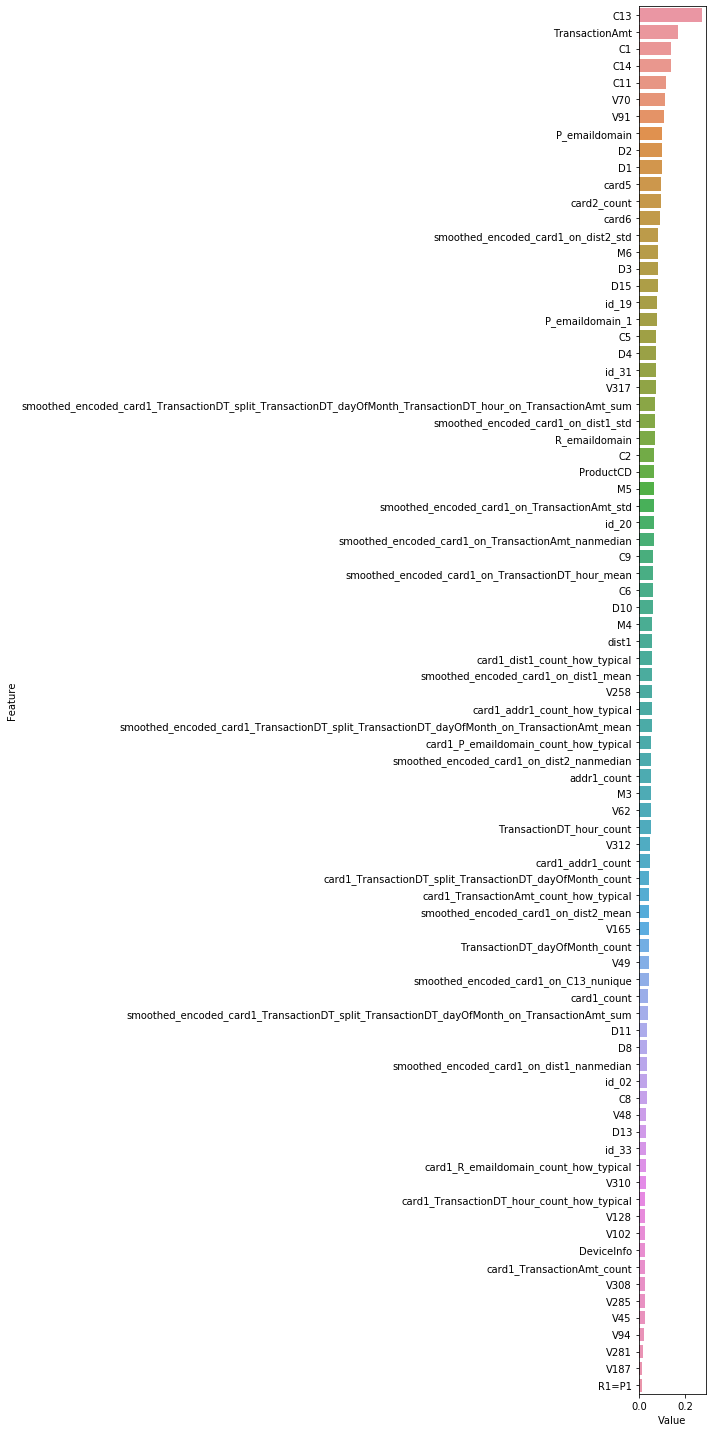

In [393]:
r = lgb_fitted.predict(
    train_test_transformed[
        (train_test_transformed['TransactionDT_split'] > 16) & \
        (train_test_transformed['TransactionDT_split'] < 19)
    ].sample(10000)[COLS_TO_USE],
    pred_contrib=True
)

mean_shap = np.abs(r).mean(axis=0)


shap_imp = pd.DataFrame(sorted(zip(mean_shap, COLS_TO_USE)), columns=['Value','Feature'])
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=shap_imp.sort_values(by="Value", ascending=False)[:150])
plt.tight_layout()
plt.show()




In [243]:
COLS_TO_USE = shap_imp.sort_values(by="Value", ascending=False)['Feature'][:35].tolist()

In [346]:
COLS_TO_USE = [f'V{i}' for i in range(1, 340)]

In [802]:
def wrapper(**cur_params):
    
    for i in ['bagging_freq', 'cat_smooth', 'max_bin', 'max_cat_to_onehot']:
        cur_params[i] = int(round(cur_params[i]))
        
    cur_params['num_leaves'] = 2 ** int(round(cur_params['num_leaves'])) - 1
    
    bound = 16
    
    cur_train = train_test_transformed[
        train_test_transformed['TransactionDT_split'] <= bound
    ]
    
    cur_test = train_test_transformed[
        (train_test_transformed['TransactionDT_split'] > bound) & \
        (train_test_transformed['TransactionDT_split'] < 19)
    ]
    
    cat_c = [i for i in CATEGORICAL_FEATURES
        if i in COLS_TO_USE]
    
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(cur_train[COLS_TO_USE], cur_train['isFraud'])
    lgb_eval = lgb.Dataset(cur_test[COLS_TO_USE], cur_test['isFraud'], reference=lgb_train)
    
    params = cur_params.copy()
    params.update(
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': ['auc'],
            'num_threads': -1
        }
    )
    
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=(lgb_train, lgb_eval),
        valid_names=('train', 'valid'),
        early_stopping_rounds=50,
        feature_name=COLS_TO_USE,
        categorical_feature=cat_c,
        verbose_eval=100
    )
    
    return gbm.best_score['valid']['auc']

In [803]:
optimizer = BayesianOptimization(
    f=wrapper,
    pbounds={
        'num_leaves': (2, 9),
        'learning_rate': (0.001, 0.05),
        'feature_fraction': (0.1, 1.0),
        'bagging_fraction': (0.1, 1.0),
        'bagging_freq': (5, 500),
        'cat_smooth': (5, 1000),
        'lambda_l1': (0.0, 10.0),
        'lambda_l2': (0.0, 10.0),
        'max_bin': (10.0, 1000.0),
        'scale_pos_weight': (0.1, 100.0),
        'max_cat_to_onehot': (4.0, 30.0)
    },
    random_state=RANDOM_STATE,
)

res = optimizer.maximize(
    init_points=25,
    n_iter=200,
)

|   iter    |  target   | baggin... | baggin... | cat_sm... | featur... | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_ca... | num_le... | scale_... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.907114	valid's auc: 0.887421
[200]	train's auc: 0.916605	valid's auc: 0.89285
[300]	train's auc: 0.92407	valid's auc: 0.896498
[400]	train's auc: 0.930353	valid's auc: 0.900515
[500]	train's auc: 0.936725	valid's auc: 0.905064
[600]	train's auc: 0.942163	valid's auc: 0.90929
[700]	train's auc: 0.946437	valid's auc: 0.91245
[800]	train's auc: 0.949982	valid's auc: 0.914891
[900]	train's auc: 0.95281	valid's auc: 0.916473
[1000]	train's auc: 0.956007	valid's auc: 0.918244
[1100]	train's auc: 0.959059	valid's auc: 0.919833
[1200]	train's auc: 0.961452	valid's auc: 0.92097
[1300]	train's auc: 0.963549	valid's auc: 0.922238
[1400]	train's auc: 0.96535	valid's auc: 0.923422
[1500]	train's auc: 0.967466	valid's auc: 0.924731
[1600]	train's auc: 0.969419	valid's auc: 0.925697
[1700]	train's auc: 0.971067	valid's auc: 0.92659
[1800]	train's auc: 0.972386	valid's auc: 0.927058
[1900]	train's auc: 0.973516	valid's 

[500]	train's auc: 0.913322	valid's auc: 0.897411
[600]	train's auc: 0.917725	valid's auc: 0.900439
[700]	train's auc: 0.921691	valid's auc: 0.903234
[800]	train's auc: 0.924985	valid's auc: 0.905039
[900]	train's auc: 0.928066	valid's auc: 0.906606
[1000]	train's auc: 0.93075	valid's auc: 0.907752
[1100]	train's auc: 0.933369	valid's auc: 0.908877
[1200]	train's auc: 0.935682	valid's auc: 0.910124
[1300]	train's auc: 0.937972	valid's auc: 0.911401
[1400]	train's auc: 0.939968	valid's auc: 0.912436
[1500]	train's auc: 0.941772	valid's auc: 0.913368
[1600]	train's auc: 0.943377	valid's auc: 0.914083
[1700]	train's auc: 0.945014	valid's auc: 0.914633
[1800]	train's auc: 0.946594	valid's auc: 0.915306
[1900]	train's auc: 0.94805	valid's auc: 0.915898
[2000]	train's auc: 0.949393	valid's auc: 0.916541
[2100]	train's auc: 0.950699	valid's auc: 0.917258
[2200]	train's auc: 0.951853	valid's auc: 0.917797
[2300]	train's auc: 0.952906	valid's auc: 0.918106
Early stopping, best iteration is:
[22

[100]	train's auc: 0.888802	valid's auc: 0.880331
[200]	train's auc: 0.899925	valid's auc: 0.889002
[300]	train's auc: 0.908333	valid's auc: 0.893836
[400]	train's auc: 0.914234	valid's auc: 0.897654
[500]	train's auc: 0.918442	valid's auc: 0.901206
[600]	train's auc: 0.923897	valid's auc: 0.904588
[700]	train's auc: 0.927593	valid's auc: 0.905977
[800]	train's auc: 0.930985	valid's auc: 0.907541
[900]	train's auc: 0.9339	valid's auc: 0.908335
[1000]	train's auc: 0.936438	valid's auc: 0.909322
[1100]	train's auc: 0.939099	valid's auc: 0.910768
[1200]	train's auc: 0.940776	valid's auc: 0.911784
[1300]	train's auc: 0.943189	valid's auc: 0.913209
[1400]	train's auc: 0.945052	valid's auc: 0.914054
[1500]	train's auc: 0.946932	valid's auc: 0.914852
[1600]	train's auc: 0.94835	valid's auc: 0.91564
[1700]	train's auc: 0.949655	valid's auc: 0.916247
[1800]	train's auc: 0.951204	valid's auc: 0.916781
[1900]	train's auc: 0.952331	valid's auc: 0.917072
[2000]	train's auc: 0.9546	valid's auc: 0.91

|  16       |  0.93     |  0.8518   |  163.8    |  190.6    |  0.1367   |  5.909    |  6.776    |  0.001813 |  517.0    |  9.889    |  6.516    |  17.52    |
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.959268	valid's auc: 0.913894
[200]	train's auc: 0.975369	valid's auc: 0.923623
[300]	train's auc: 0.985093	valid's auc: 0.926354
Early stopping, best iteration is:
[307]	train's auc: 0.985451	valid's auc: 0.926485
|  17       |  0.9265   |  0.7218   |  196.4    |  937.0    |  0.2238   |  3.411    |  1.135    |  0.04631  |  878.6    |  10.71    |  6.62     |  81.74    |
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.946313	valid's auc: 0.906665
[200]	train's auc: 0.962131	valid's auc: 0.917062
[300]	train's auc: 0.972444	valid's auc: 0.922019
[400]	train's auc: 0.979624	valid's auc: 0.924732
[500]	train's auc: 0.983206	valid's auc: 0.925608
[600]	train's auc: 0.987103	valid's auc: 0.926155
Early stopping, best iter

[2200]	train's auc: 0.910579	valid's auc: 0.89671
[2300]	train's auc: 0.911584	valid's auc: 0.897623
[2400]	train's auc: 0.91272	valid's auc: 0.898411
[2500]	train's auc: 0.913554	valid's auc: 0.899392
[2600]	train's auc: 0.914333	valid's auc: 0.899764
[2700]	train's auc: 0.915141	valid's auc: 0.900589
[2800]	train's auc: 0.915998	valid's auc: 0.901319
[2900]	train's auc: 0.91699	valid's auc: 0.902053
[3000]	train's auc: 0.917936	valid's auc: 0.902637
[3100]	train's auc: 0.918953	valid's auc: 0.903311
[3200]	train's auc: 0.919669	valid's auc: 0.903796
[3300]	train's auc: 0.920483	valid's auc: 0.90435
Early stopping, best iteration is:
[3309]	train's auc: 0.920549	valid's auc: 0.904359
|  24       |  0.9044   |  0.3852   |  88.9     |  559.0    |  0.9425   |  6.96     |  5.701    |  0.005762 |  618.9    |  29.74    |  2.981    |  51.88    |
Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.983194	valid's auc: 0.92351
[200]	train's auc: 0.992271	valid's a

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.923148	valid's auc: 0.899509
[200]	train's auc: 0.939273	valid's auc: 0.908106
[300]	train's auc: 0.946901	valid's auc: 0.910669
[400]	train's auc: 0.951464	valid's auc: 0.912176
[500]	train's auc: 0.954993	valid's auc: 0.913511
[600]	train's auc: 0.960712	valid's auc: 0.915799
[700]	train's auc: 0.964111	valid's auc: 0.916376
Early stopping, best iteration is:
[660]	train's auc: 0.962907	valid's auc: 0.916668
|  26       |  0.9167   |  0.314    |  488.3    |  981.5    |  0.1954   |  9.604    |  7.896    |  0.04855  |  602.7    |  8.281    |  7.278    |  1.498    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.879887	valid's auc: 0.869526
[200]	train's auc: 0.896037	valid's auc: 0.881129
[300]	train's auc: 0.906107	valid's auc: 0.88881
[400]	train's auc: 0.912956	valid's auc: 0.893572
[500]	train's auc: 0.918345	valid's auc: 0.897087
[600]	train's auc: 0.923085	valid's auc: 0.900276
[700]	train's auc: 0.927232	valid's auc: 0.902451
[800]	train's auc: 0.930879	valid's auc: 0.904218
[900]	train's auc: 0.934086	valid's auc: 0.905072
[1000]	train's auc: 0.93714	valid's auc: 0.906191
[1100]	train's auc: 0.939426	valid's auc: 0.906723
[1200]	train's auc: 0.941644	valid's auc: 0.907729
[1300]	train's auc: 0.943668	valid's auc: 0.908776
[1400]	train's auc: 0.945563	valid's auc: 0.9096
[1500]	train's auc: 0.947729	valid's auc: 0.910394
[1600]	train's auc: 0.949419	valid's auc: 0.910923
[1700]	train's auc: 0.950828	valid's auc: 0.911219
Early stopping, best iteration is:
[1661]	train's auc: 0.950299	valid's auc: 0.91128

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.976984	valid's auc: 0.928019
[200]	train's auc: 0.989872	valid's auc: 0.933923
[300]	train's auc: 0.994702	valid's auc: 0.935035
[400]	train's auc: 0.996963	valid's auc: 0.935061
Early stopping, best iteration is:
[362]	train's auc: 0.996259	valid's auc: 0.935248
|  28       |  0.9352   |  0.9773   |  8.164    |  989.6    |  0.9526   |  2.299    |  5.462    |  0.03385  |  29.04    |  10.42    |  8.269    |  5.678    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.90496	valid's auc: 0.88479
[200]	train's auc: 0.935781	valid's auc: 0.904301
[300]	train's auc: 0.950512	valid's auc: 0.911615
[400]	train's auc: 0.958966	valid's auc: 0.91447
[500]	train's auc: 0.96464	valid's auc: 0.916328
[600]	train's auc: 0.968895	valid's auc: 0.918474
[700]	train's auc: 0.972486	valid's auc: 0.919175
[800]	train's auc: 0.975187	valid's auc: 0.919693
Early stopping, best iteration is:
[765]	train's auc: 0.974272	valid's auc: 0.91986
|  29       |  0.9199   |  0.5576   |  15.31    |  984.4    |  0.7565   |  3.186    |  3.835    |  0.03491  |  498.3    |  10.17    |  6.802    |  0.1997   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.914507	valid's auc: 0.894613
[200]	train's auc: 0.931739	valid's auc: 0.907093
[300]	train's auc: 0.940704	valid's auc: 0.911656
[400]	train's auc: 0.946107	valid's auc: 0.913617
[500]	train's auc: 0.952416	valid's auc: 0.914772
[600]	train's auc: 0.957719	valid's auc: 0.916047
[700]	train's auc: 0.961078	valid's auc: 0.917125
[800]	train's auc: 0.963521	valid's auc: 0.917425
Early stopping, best iteration is:
[824]	train's auc: 0.96403	valid's auc: 0.917835
|  30       |  0.9178   |  0.3663   |  455.9    |  992.1    |  0.6868   |  2.901    |  9.654    |  0.02987  |  992.3    |  4.238    |  5.075    |  96.85    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.964386	valid's auc: 0.914539
[200]	train's auc: 0.978218	valid's auc: 0.923963
[300]	train's auc: 0.986591	valid's auc: 0.928673
[400]	train's auc: 0.990946	valid's auc: 0.930566
[500]	train's auc: 0.993464	valid's auc: 0.931809
[600]	train's auc: 0.995083	valid's auc: 0.932317
[700]	train's auc: 0.996145	valid's auc: 0.932437
[800]	train's auc: 0.996918	valid's auc: 0.932793
Early stopping, best iteration is:
[821]	train's auc: 0.997043	valid's auc: 0.932936
|  31       |  0.9329   |  0.9536   |  8.774    |  657.3    |  0.3866   |  3.941    |  9.92     |  0.02446  |  10.27    |  16.33    |  8.122    |  97.41    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.964907	valid's auc: 0.923455
[200]	train's auc: 0.978824	valid's auc: 0.930378
[300]	train's auc: 0.986193	valid's auc: 0.931832
Early stopping, best iteration is:
[322]	train's auc: 0.987282	valid's auc: 0.932005
|  32       |  0.932    |  0.8539   |  243.1    |  646.4    |  0.8255   |  2.184    |  7.419    |  0.0346   |  985.3    |  6.289    |  7.226    |  11.54    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.979072	valid's auc: 0.916272
[200]	train's auc: 0.990187	valid's auc: 0.920812
[300]	train's auc: 0.994609	valid's auc: 0.922449
Early stopping, best iteration is:
[308]	train's auc: 0.99482	valid's auc: 0.922641
|  33       |  0.9226   |  0.2717   |  9.45     |  15.6     |  0.7845   |  1.112    |  4.973    |  0.02762  |  11.42    |  18.09    |  8.82     |  40.59    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.844204	valid's auc: 0.84608
[200]	train's auc: 0.859836	valid's auc: 0.855439
[300]	train's auc: 0.866155	valid's auc: 0.859649
[400]	train's auc: 0.872196	valid's auc: 0.863854
[500]	train's auc: 0.877084	valid's auc: 0.867546
[600]	train's auc: 0.880897	valid's auc: 0.8706
[700]	train's auc: 0.883895	valid's auc: 0.87305
[800]	train's auc: 0.886511	valid's auc: 0.874891
[900]	train's auc: 0.888814	valid's auc: 0.876731
[1000]	train's auc: 0.890922	valid's auc: 0.87831
[1100]	train's auc: 0.892604	valid's auc: 0.879736
[1200]	train's auc: 0.894621	valid's auc: 0.881154
[1300]	train's auc: 0.895959	valid's auc: 0.88206
[1400]	train's auc: 0.897035	valid's auc: 0.882739
[1500]	train's auc: 0.897935	valid's auc: 0.883301
[1600]	train's auc: 0.898847	valid's auc: 0.884113
[1700]	train's auc: 0.899849	valid's auc: 0.884969
[1800]	train's auc: 0.900884	valid's auc: 0.885603
[1900]	train's auc: 0.90171	valid's

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.973658	valid's auc: 0.912789
[200]	train's auc: 0.988131	valid's auc: 0.923359
[300]	train's auc: 0.993496	valid's auc: 0.925949
[400]	train's auc: 0.996075	valid's auc: 0.926319
[500]	train's auc: 0.997463	valid's auc: 0.927025
Early stopping, best iteration is:
[475]	train's auc: 0.997213	valid's auc: 0.927195
|  35       |  0.9272   |  0.7429   |  7.294    |  905.8    |  0.1923   |  6.996    |  0.2371   |  0.0395   |  997.6    |  29.79    |  8.168    |  97.79    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.883153	valid's auc: 0.876233
[200]	train's auc: 0.888546	valid's auc: 0.880617
[300]	train's auc: 0.892843	valid's auc: 0.884366
[400]	train's auc: 0.898178	valid's auc: 0.888484
[500]	train's auc: 0.903074	valid's auc: 0.892257
[600]	train's auc: 0.907434	valid's auc: 0.895543
[700]	train's auc: 0.910954	valid's auc: 0.897809
[800]	train's auc: 0.913889	valid's auc: 0.899455
[900]	train's auc: 0.916354	valid's auc: 0.900887
[1000]	train's auc: 0.918724	valid's auc: 0.902024
[1100]	train's auc: 0.921353	valid's auc: 0.903469
[1200]	train's auc: 0.923488	valid's auc: 0.904626
[1300]	train's auc: 0.925514	valid's auc: 0.905546
[1400]	train's auc: 0.927118	valid's auc: 0.906199
[1500]	train's auc: 0.928673	valid's auc: 0.906929
[1600]	train's auc: 0.930611	valid's auc: 0.907729
[1700]	train's auc: 0.93236	valid's auc: 0.908562
[1800]	train's auc: 0.933826	valid's auc: 0.909111
[1900]	train's auc: 0.935132	v

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.925289	valid's auc: 0.898701
[200]	train's auc: 0.948366	valid's auc: 0.912528
[300]	train's auc: 0.959032	valid's auc: 0.918297
[400]	train's auc: 0.965516	valid's auc: 0.921101
[500]	train's auc: 0.969803	valid's auc: 0.923301
[600]	train's auc: 0.973864	valid's auc: 0.925097
[700]	train's auc: 0.976602	valid's auc: 0.92588
Early stopping, best iteration is:
[676]	train's auc: 0.976054	valid's auc: 0.92594
|  37       |  0.9259   |  0.8373   |  498.1    |  566.4    |  0.9046   |  5.161    |  5.756    |  0.03698  |  438.4    |  8.618    |  5.797    |  0.7725   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.908711	valid's auc: 0.892001
[200]	train's auc: 0.920458	valid's auc: 0.902049
[300]	train's auc: 0.928291	valid's auc: 0.907141
[400]	train's auc: 0.933564	valid's auc: 0.909941
[500]	train's auc: 0.939165	valid's auc: 0.913102
[600]	train's auc: 0.943753	valid's auc: 0.915835
[700]	train's auc: 0.947095	valid's auc: 0.917572
[800]	train's auc: 0.949797	valid's auc: 0.918922
[900]	train's auc: 0.951997	valid's auc: 0.920319
[1000]	train's auc: 0.956244	valid's auc: 0.921932
[1100]	train's auc: 0.958823	valid's auc: 0.922582
[1200]	train's auc: 0.960693	valid's auc: 0.923202
[1300]	train's auc: 0.962217	valid's auc: 0.923664
[1400]	train's auc: 0.964315	valid's auc: 0.924438
[1500]	train's auc: 0.966591	valid's auc: 0.925451
[1600]	train's auc: 0.96809	valid's auc: 0.925629
[1700]	train's auc: 0.969298	valid's auc: 0.92592
[1800]	train's auc: 0.970146	valid's auc: 0.92598
Early stopping, best iteration i

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.970124	valid's auc: 0.912988
[200]	train's auc: 0.979233	valid's auc: 0.920967
[300]	train's auc: 0.985464	valid's auc: 0.926324
[400]	train's auc: 0.989364	valid's auc: 0.928943
[500]	train's auc: 0.992025	valid's auc: 0.930497
[600]	train's auc: 0.993901	valid's auc: 0.93139
[700]	train's auc: 0.995235	valid's auc: 0.931755
Early stopping, best iteration is:
[709]	train's auc: 0.995335	valid's auc: 0.931873
|  39       |  0.9319   |  0.6612   |  9.347    |  10.85    |  0.8304   |  2.337    |  6.675    |  0.01063  |  651.5    |  6.135    |  7.895    |  27.79    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.902387	valid's auc: 0.882736
[200]	train's auc: 0.921169	valid's auc: 0.895609
[300]	train's auc: 0.93311	valid's auc: 0.902679
[400]	train's auc: 0.942198	valid's auc: 0.907831
[500]	train's auc: 0.948644	valid's auc: 0.911772
[600]	train's auc: 0.953676	valid's auc: 0.913956
[700]	train's auc: 0.958218	valid's auc: 0.9155
[800]	train's auc: 0.961842	valid's auc: 0.915966
Early stopping, best iteration is:
[768]	train's auc: 0.96079	valid's auc: 0.916155
|  40       |  0.9162   |  0.1418   |  120.3    |  848.0    |  0.1557   |  0.7972   |  0.2621   |  0.01705  |  85.53    |  4.487    |  6.876    |  0.6817   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.986894	valid's auc: 0.918176
[200]	train's auc: 0.995975	valid's auc: 0.928109
[300]	train's auc: 0.998284	valid's auc: 0.930262
[400]	train's auc: 0.999166	valid's auc: 0.930624
Early stopping, best iteration is:
[351]	train's auc: 0.998809	valid's auc: 0.931061
|  41       |  0.9311   |  0.8467   |  26.33    |  975.9    |  0.8584   |  1.893    |  4.339    |  0.03358  |  13.44    |  11.24    |  8.776    |  91.67    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.986275	valid's auc: 0.921834
[200]	train's auc: 0.991126	valid's auc: 0.927026
[300]	train's auc: 0.996802	valid's auc: 0.926828
Early stopping, best iteration is:
[273]	train's auc: 0.992289	valid's auc: 0.927458
|  42       |  0.9275   |  0.7673   |  278.6    |  12.17    |  0.2597   |  0.2949   |  6.546    |  0.04699  |  538.4    |  4.11     |  8.704    |  96.99    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.973026	valid's auc: 0.925244
[200]	train's auc: 0.985051	valid's auc: 0.931133
[300]	train's auc: 0.990417	valid's auc: 0.932412
[400]	train's auc: 0.992862	valid's auc: 0.932706
Early stopping, best iteration is:
[409]	train's auc: 0.993026	valid's auc: 0.932837
|  43       |  0.9328   |  0.8991   |  493.1    |  282.4    |  0.7543   |  4.743    |  6.013    |  0.02824  |  16.73    |  23.5     |  8.06     |  8.329    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.895901	valid's auc: 0.879042
[200]	train's auc: 0.907123	valid's auc: 0.887199
[300]	train's auc: 0.915122	valid's auc: 0.892797
[400]	train's auc: 0.92175	valid's auc: 0.897019
[500]	train's auc: 0.927966	valid's auc: 0.900843
[600]	train's auc: 0.932757	valid's auc: 0.903618
[700]	train's auc: 0.936956	valid's auc: 0.905606
[800]	train's auc: 0.940668	valid's auc: 0.907538
[900]	train's auc: 0.943944	valid's auc: 0.90929
[1000]	train's auc: 0.946688	valid's auc: 0.910703
[1100]	train's auc: 0.949392	valid's auc: 0.912059
[1200]	train's auc: 0.95187	valid's auc: 0.913491
[1300]	train's auc: 0.954116	valid's auc: 0.914726
[1400]	train's auc: 0.956112	valid's auc: 0.915602
[1500]	train's auc: 0.95808	valid's auc: 0.91653
[1600]	train's auc: 0.959672	valid's auc: 0.917317
[1700]	train's auc: 0.961281	valid's auc: 0.918191
[1800]	train's auc: 0.962552	valid's auc: 0.918886
[1900]	train's auc: 0.963893	valid

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.959034	valid's auc: 0.898368
[200]	train's auc: 0.978062	valid's auc: 0.908375
[300]	train's auc: 0.987304	valid's auc: 0.909422
Early stopping, best iteration is:
[301]	train's auc: 0.98738	valid's auc: 0.909581
|  45       |  0.9096   |  0.1002   |  7.833    |  37.19    |  0.5798   |  5.465    |  9.303    |  0.04462  |  963.2    |  13.11    |  8.674    |  94.34    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.984766	valid's auc: 0.925467
[200]	train's auc: 0.994897	valid's auc: 0.930842
Early stopping, best iteration is:
[245]	train's auc: 0.996506	valid's auc: 0.931364
|  46       |  0.9314   |  0.9388   |  27.93    |  819.8    |  0.5457   |  0.4907   |  9.96     |  0.04667  |  611.1    |  8.383    |  7.783    |  92.17    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.990673	valid's auc: 0.932475
Early stopping, best iteration is:
[148]	train's auc: 0.993866	valid's auc: 0.933582
|  47       |  0.9336   |  0.855    |  486.1    |  946.2    |  0.8008   |  2.165    |  4.296    |  0.04867  |  289.4    |  26.91    |  8.732    |  3.664    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.927273	valid's auc: 0.895545
[200]	train's auc: 0.942713	valid's auc: 0.905028
[300]	train's auc: 0.949963	valid's auc: 0.908538
[400]	train's auc: 0.953849	valid's auc: 0.909768
Early stopping, best iteration is:
[403]	train's auc: 0.953933	valid's auc: 0.909809
|  48       |  0.9098   |  0.2608   |  469.0    |  21.16    |  0.7372   |  8.533    |  9.806    |  0.03063  |  122.5    |  23.81    |  8.798    |  1.021    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960052	valid's auc: 0.911753
[200]	train's auc: 0.978769	valid's auc: 0.924073
[300]	train's auc: 0.986664	valid's auc: 0.926848
[400]	train's auc: 0.991083	valid's auc: 0.928225
Early stopping, best iteration is:
[414]	train's auc: 0.991485	valid's auc: 0.928373
|  49       |  0.9284   |  0.8599   |  165.5    |  746.7    |  0.8458   |  0.9227   |  6.383    |  0.03196  |  998.6    |  14.23    |  6.967    |  99.11    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.959847	valid's auc: 0.913339
[200]	train's auc: 0.976075	valid's auc: 0.924465
[300]	train's auc: 0.982482	valid's auc: 0.925705
[400]	train's auc: 0.985503	valid's auc: 0.926348
Early stopping, best iteration is:
[398]	train's auc: 0.985462	valid's auc: 0.926414
|  50       |  0.9264   |  0.7444   |  478.2    |  998.8    |  0.5181   |  8.632    |  3.276    |  0.03687  |  457.4    |  28.39    |  7.089    |  99.7     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.937252	valid's auc: 0.894701
[200]	train's auc: 0.945466	valid's auc: 0.898307
[300]	train's auc: 0.948438	valid's auc: 0.901175
[400]	train's auc: 0.952877	valid's auc: 0.904752
[500]	train's auc: 0.956672	valid's auc: 0.907428
[600]	train's auc: 0.95916	valid's auc: 0.909241
[700]	train's auc: 0.961172	valid's auc: 0.910347
[800]	train's auc: 0.964003	valid's auc: 0.911889
[900]	train's auc: 0.966493	valid's auc: 0.913621
[1000]	train's auc: 0.968819	valid's auc: 0.915102
[1100]	train's auc: 0.971265	valid's auc: 0.917048
[1200]	train's auc: 0.973619	valid's auc: 0.918992
[1300]	train's auc: 0.975552	valid's auc: 0.920345
[1400]	train's auc: 0.977306	valid's auc: 0.921476
[1500]	train's auc: 0.979089	valid's auc: 0.92251
[1600]	train's auc: 0.980663	valid's auc: 0.923464
[1700]	train's auc: 0.982013	valid's auc: 0.924143
[1800]	train's auc: 0.983217	valid's auc: 0.92475
[1900]	train's auc: 0.984378	val

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.991194	valid's auc: 0.914953
[200]	train's auc: 0.997884	valid's auc: 0.925265
[300]	train's auc: 0.99927	valid's auc: 0.927811
[400]	train's auc: 0.999713	valid's auc: 0.928962
Early stopping, best iteration is:
[432]	train's auc: 0.999778	valid's auc: 0.929043
|  52       |  0.929    |  0.9121   |  71.65    |  997.4    |  0.9731   |  1.459    |  3.211    |  0.03584  |  982.0    |  8.856    |  8.553    |  95.14    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945852	valid's auc: 0.909948
[200]	train's auc: 0.968326	valid's auc: 0.921574
[300]	train's auc: 0.977858	valid's auc: 0.925658
[400]	train's auc: 0.984505	valid's auc: 0.928109
[500]	train's auc: 0.98848	valid's auc: 0.929202
[600]	train's auc: 0.990771	valid's auc: 0.92933
Early stopping, best iteration is:
[581]	train's auc: 0.990425	valid's auc: 0.929496
|  53       |  0.9295   |  0.6942   |  327.8    |  525.5    |  0.3528   |  0.3841   |  6.208    |  0.04166  |  593.0    |  18.7     |  8.265    |  0.4634   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.963916	valid's auc: 0.926057
[200]	train's auc: 0.979284	valid's auc: 0.932982
[300]	train's auc: 0.987246	valid's auc: 0.935096
[400]	train's auc: 0.991588	valid's auc: 0.935858
Early stopping, best iteration is:
[395]	train's auc: 0.99143	valid's auc: 0.935916
|  54       |  0.9359   |  0.7621   |  10.16    |  741.4    |  0.6302   |  2.997    |  0.2442   |  0.03301  |  875.1    |  12.94    |  7.287    |  6.448    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.96343	valid's auc: 0.913269
[200]	train's auc: 0.971747	valid's auc: 0.920012
[300]	train's auc: 0.974252	valid's auc: 0.919771
Early stopping, best iteration is:
[252]	train's auc: 0.973381	valid's auc: 0.920397
|  55       |  0.9204   |  0.4377   |  496.7    |  645.4    |  0.5744   |  2.743    |  9.771    |  0.04464  |  663.5    |  26.04    |  8.343    |  91.82    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.948113	valid's auc: 0.891287
[200]	train's auc: 0.967187	valid's auc: 0.903257
[300]	train's auc: 0.977409	valid's auc: 0.90548
Early stopping, best iteration is:
[266]	train's auc: 0.97448	valid's auc: 0.905917
|  56       |  0.9059   |  0.1069   |  6.209    |  992.8    |  0.4391   |  0.3507   |  2.594    |  0.03003  |  219.1    |  26.48    |  8.42     |  80.8     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.950791	valid's auc: 0.912325
[200]	train's auc: 0.963283	valid's auc: 0.91881
[300]	train's auc: 0.970976	valid's auc: 0.922324
[400]	train's auc: 0.978306	valid's auc: 0.925087
[500]	train's auc: 0.981144	valid's auc: 0.925488
[600]	train's auc: 0.984269	valid's auc: 0.927027
Early stopping, best iteration is:
[625]	train's auc: 0.985178	valid's auc: 0.927276
|  57       |  0.9273   |  0.4408   |  271.7    |  963.7    |  0.3055   |  7.628    |  6.597    |  0.03621  |  14.34    |  22.6     |  8.833    |  2.978    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.934907	valid's auc: 0.900932
[200]	train's auc: 0.945247	valid's auc: 0.907741
[300]	train's auc: 0.960355	valid's auc: 0.913237
[400]	train's auc: 0.965591	valid's auc: 0.915211
[500]	train's auc: 0.973719	valid's auc: 0.919575
[600]	train's auc: 0.976705	valid's auc: 0.921201
[700]	train's auc: 0.980759	valid's auc: 0.922695
[800]	train's auc: 0.982452	valid's auc: 0.923158
Early stopping, best iteration is:
[838]	train's auc: 0.983831	valid's auc: 0.923445
|  58       |  0.9234   |  0.2307   |  196.2    |  812.4    |  0.3087   |  9.658    |  8.521    |  0.01686  |  423.7    |  5.391    |  8.993    |  11.03    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.977575	valid's auc: 0.911095
[200]	train's auc: 0.986135	valid's auc: 0.920759
[300]	train's auc: 0.99169	valid's auc: 0.927256
[400]	train's auc: 0.994926	valid's auc: 0.930886
[500]	train's auc: 0.996639	valid's auc: 0.932622
[600]	train's auc: 0.997631	valid's auc: 0.933554
Early stopping, best iteration is:
[612]	train's auc: 0.997734	valid's auc: 0.933668
|  59       |  0.9337   |  0.7127   |  8.054    |  977.2    |  0.5452   |  6.36     |  8.952    |  0.01417  |  778.4    |  20.66    |  8.716    |  93.39    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.966158	valid's auc: 0.907511
[200]	train's auc: 0.975282	valid's auc: 0.914531
[300]	train's auc: 0.981013	valid's auc: 0.919164
[400]	train's auc: 0.985243	valid's auc: 0.922579
[500]	train's auc: 0.988861	valid's auc: 0.925901
[600]	train's auc: 0.991452	valid's auc: 0.928248
[700]	train's auc: 0.99328	valid's auc: 0.930054
[800]	train's auc: 0.994623	valid's auc: 0.930977
[900]	train's auc: 0.995589	valid's auc: 0.931623
[1000]	train's auc: 0.996335	valid's auc: 0.932068
[1100]	train's auc: 0.996919	valid's auc: 0.932366
Early stopping, best iteration is:
[1101]	train's auc: 0.996923	valid's auc: 0.932373
|  60       |  0.9324   |  0.7543   |  23.81    |  219.0    |  0.5525   |  9.325    |  8.454    |  0.008038 |  15.2     |  27.22    |  8.954    |  90.36    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.891026	valid's auc: 0.879649
[200]	train's auc: 0.903183	valid's auc: 0.888817
[300]	train's auc: 0.91135	valid's auc: 0.89498
[400]	train's auc: 0.918609	valid's auc: 0.899474
[500]	train's auc: 0.923869	valid's auc: 0.903748
[600]	train's auc: 0.92794	valid's auc: 0.906702
[700]	train's auc: 0.931678	valid's auc: 0.908493
[800]	train's auc: 0.935115	valid's auc: 0.909691
[900]	train's auc: 0.937967	valid's auc: 0.911407
[1000]	train's auc: 0.940767	valid's auc: 0.912286
[1100]	train's auc: 0.942858	valid's auc: 0.91362
[1200]	train's auc: 0.945028	valid's auc: 0.914982
[1300]	train's auc: 0.947089	valid's auc: 0.915535
[1400]	train's auc: 0.948985	valid's auc: 0.916613
[1500]	train's auc: 0.950721	valid's auc: 0.917695
[1600]	train's auc: 0.952295	valid's auc: 0.918754
[1700]	train's auc: 0.953715	valid's auc: 0.919413
[1800]	train's auc: 0.955159	valid's auc: 0.919818
[1900]	train's auc: 0.956399	vali

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.96017	valid's auc: 0.904309
[200]	train's auc: 0.978984	valid's auc: 0.91453
[300]	train's auc: 0.98784	valid's auc: 0.919091
[400]	train's auc: 0.992491	valid's auc: 0.91961
Early stopping, best iteration is:
[353]	train's auc: 0.990614	valid's auc: 0.920157
|  62       |  0.9202   |  0.3245   |  73.78    |  19.89    |  0.7897   |  1.174    |  2.542    |  0.01993  |  651.7    |  29.0     |  8.577    |  99.16    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.952097	valid's auc: 0.910228
[200]	train's auc: 0.955997	valid's auc: 0.910993
Early stopping, best iteration is:
[152]	train's auc: 0.955062	valid's auc: 0.911639
|  63       |  0.9116   |  0.2356   |  474.5    |  492.6    |  0.5889   |  0.5756   |  9.197    |  0.04567  |  227.6    |  29.26    |  8.749    |  8.861    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.892137	valid's auc: 0.873525
[200]	train's auc: 0.915472	valid's auc: 0.891593
[300]	train's auc: 0.92571	valid's auc: 0.897757
[400]	train's auc: 0.931235	valid's auc: 0.899955
[500]	train's auc: 0.934923	valid's auc: 0.901346
[600]	train's auc: 0.940428	valid's auc: 0.903621
[700]	train's auc: 0.942994	valid's auc: 0.904145
[800]	train's auc: 0.944185	valid's auc: 0.904595
Early stopping, best iteration is:
[779]	train's auc: 0.944185	valid's auc: 0.904595
|  64       |  0.9046   |  0.309    |  496.5    |  406.5    |  0.7258   |  8.416    |  4.272    |  0.03026  |  690.7    |  7.81     |  7.45     |  0.2781   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.899517	valid's auc: 0.880843
[200]	train's auc: 0.903635	valid's auc: 0.884323
[300]	train's auc: 0.905774	valid's auc: 0.886066
[400]	train's auc: 0.908321	valid's auc: 0.888739
[500]	train's auc: 0.911029	valid's auc: 0.890909
[600]	train's auc: 0.915715	valid's auc: 0.893362
[700]	train's auc: 0.919807	valid's auc: 0.895895
[800]	train's auc: 0.923178	valid's auc: 0.897517
[900]	train's auc: 0.925979	valid's auc: 0.898851
[1000]	train's auc: 0.928636	valid's auc: 0.900209
[1100]	train's auc: 0.932215	valid's auc: 0.902264
[1200]	train's auc: 0.93494	valid's auc: 0.904087
[1300]	train's auc: 0.937183	valid's auc: 0.905563
[1400]	train's auc: 0.938868	valid's auc: 0.90677
[1500]	train's auc: 0.940389	valid's auc: 0.907868
[1600]	train's auc: 0.942817	valid's auc: 0.908932
[1700]	train's auc: 0.944755	valid's auc: 0.909768
[1800]	train's auc: 0.946332	valid's auc: 0.910618
[1900]	train's auc: 0.94767	val

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.932991	valid's auc: 0.901443
[200]	train's auc: 0.940703	valid's auc: 0.904889
[300]	train's auc: 0.945347	valid's auc: 0.907237
[400]	train's auc: 0.949061	valid's auc: 0.909195
[500]	train's auc: 0.951988	valid's auc: 0.911153
[600]	train's auc: 0.954356	valid's auc: 0.912614
[700]	train's auc: 0.956447	valid's auc: 0.914302
[800]	train's auc: 0.958313	valid's auc: 0.915642
[900]	train's auc: 0.960037	valid's auc: 0.916686
[1000]	train's auc: 0.961641	valid's auc: 0.917761
[1100]	train's auc: 0.963122	valid's auc: 0.918705
[1200]	train's auc: 0.964523	valid's auc: 0.919641
[1300]	train's auc: 0.96594	valid's auc: 0.920527
[1400]	train's auc: 0.967208	valid's auc: 0.921398
[1500]	train's auc: 0.968448	valid's auc: 0.922192
[1600]	train's auc: 0.969683	valid's auc: 0.923072
[1700]	train's auc: 0.970847	valid's auc: 0.923853
[1800]	train's auc: 0.97196	valid's auc: 0.924669
[1900]	train's auc: 0.97298	val

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.875265	valid's auc: 0.864545
[200]	train's auc: 0.892492	valid's auc: 0.877114
[300]	train's auc: 0.900693	valid's auc: 0.882633
[400]	train's auc: 0.907256	valid's auc: 0.883254
Early stopping, best iteration is:
[368]	train's auc: 0.905468	valid's auc: 0.884611
|  67       |  0.8846   |  0.1382   |  164.1    |  26.24    |  0.8336   |  9.93     |  9.345    |  0.03526  |  19.6     |  5.836    |  3.166    |  99.54    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.893569	valid's auc: 0.876107
[200]	train's auc: 0.919019	valid's auc: 0.892795
[300]	train's auc: 0.931069	valid's auc: 0.898919
[400]	train's auc: 0.938509	valid's auc: 0.901982
[500]	train's auc: 0.943806	valid's auc: 0.903096
[600]	train's auc: 0.948197	valid's auc: 0.904555
[700]	train's auc: 0.951646	valid's auc: 0.905792
Early stopping, best iteration is:
[699]	train's auc: 0.951645	valid's auc: 0.905851
|  68       |  0.9059   |  0.2817   |  5.047    |  217.4    |  0.7666   |  3.427    |  9.95     |  0.04803  |  272.2    |  29.49    |  8.198    |  0.1262   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.90915	valid's auc: 0.89023
[200]	train's auc: 0.918415	valid's auc: 0.895512
[300]	train's auc: 0.925111	valid's auc: 0.899625
[400]	train's auc: 0.929629	valid's auc: 0.902546
[500]	train's auc: 0.938071	valid's auc: 0.906495
[600]	train's auc: 0.942172	valid's auc: 0.908152
[700]	train's auc: 0.944782	valid's auc: 0.908984
[800]	train's auc: 0.946348	valid's auc: 0.908967
[900]	train's auc: 0.951905	valid's auc: 0.911031
[1000]	train's auc: 0.955301	valid's auc: 0.912452
[1100]	train's auc: 0.957119	valid's auc: 0.913307
Early stopping, best iteration is:
[1099]	train's auc: 0.957112	valid's auc: 0.913325
|  69       |  0.9133   |  0.1503   |  406.1    |  193.1    |  0.7234   |  3.633    |  0.6375   |  0.009045 |  11.48    |  4.721    |  7.124    |  2.45     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.921397	valid's auc: 0.89712
[200]	train's auc: 0.938752	valid's auc: 0.910149
[300]	train's auc: 0.948068	valid's auc: 0.914954
[400]	train's auc: 0.953821	valid's auc: 0.916859
[500]	train's auc: 0.958717	valid's auc: 0.917949
[600]	train's auc: 0.964519	valid's auc: 0.920503
[700]	train's auc: 0.967946	valid's auc: 0.921684
[800]	train's auc: 0.970708	valid's auc: 0.922659
[900]	train's auc: 0.972828	valid's auc: 0.923438
[1000]	train's auc: 0.975252	valid's auc: 0.923977
[1100]	train's auc: 0.977863	valid's auc: 0.924609
[1200]	train's auc: 0.979481	valid's auc: 0.924953
[1300]	train's auc: 0.98068	valid's auc: 0.925313
Early stopping, best iteration is:
[1338]	train's auc: 0.981104	valid's auc: 0.925481
|  70       |  0.9255   |  0.5476   |  490.4    |  512.8    |  0.7102   |  9.978    |  6.602    |  0.03711  |  17.21    |  26.86    |  4.906    |  96.21    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.964717	valid's auc: 0.908578
[200]	train's auc: 0.980099	valid's auc: 0.92159
[300]	train's auc: 0.987741	valid's auc: 0.925163
[400]	train's auc: 0.99166	valid's auc: 0.927029
[500]	train's auc: 0.994054	valid's auc: 0.9274
[600]	train's auc: 0.995662	valid's auc: 0.927656
Early stopping, best iteration is:
[550]	train's auc: 0.995027	valid's auc: 0.927811
|  71       |  0.9278   |  0.9741   |  488.9    |  142.3    |  0.1279   |  2.213    |  9.753    |  0.03251  |  289.8    |  11.1     |  8.234    |  95.72    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.967764	valid's auc: 0.910498
[200]	train's auc: 0.981385	valid's auc: 0.921209
[300]	train's auc: 0.990582	valid's auc: 0.92398
Early stopping, best iteration is:
[324]	train's auc: 0.991351	valid's auc: 0.92417
|  72       |  0.9242   |  0.7078   |  202.2    |  550.7    |  0.9233   |  0.3411   |  9.393    |  0.03148  |  17.13    |  24.86    |  8.276    |  91.97    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.968202	valid's auc: 0.917112
[200]	train's auc: 0.98276	valid's auc: 0.925601
[300]	train's auc: 0.990464	valid's auc: 0.928645
[400]	train's auc: 0.993572	valid's auc: 0.929445
Early stopping, best iteration is:
[388]	train's auc: 0.993297	valid's auc: 0.92959
|  73       |  0.9296   |  0.8212   |  227.4    |  204.8    |  0.7877   |  0.3298   |  6.021    |  0.04089  |  646.3    |  4.595    |  6.833    |  99.88    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972862	valid's auc: 0.917735
[200]	train's auc: 0.981475	valid's auc: 0.923057
Early stopping, best iteration is:
[213]	train's auc: 0.982049	valid's auc: 0.923509
|  74       |  0.9235   |  0.614    |  489.3    |  21.38    |  0.1624   |  0.6266   |  9.969    |  0.03653  |  451.5    |  8.812    |  8.962    |  12.96    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.968967	valid's auc: 0.916537
[200]	train's auc: 0.983895	valid's auc: 0.925233
[300]	train's auc: 0.990957	valid's auc: 0.926927
Early stopping, best iteration is:
[349]	train's auc: 0.992629	valid's auc: 0.927291
|  75       |  0.9273   |  0.8614   |  229.4    |  413.0    |  0.8333   |  0.8807   |  3.827    |  0.04185  |  977.3    |  6.481    |  7.009    |  93.39    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.819867	valid's auc: 0.82147
[200]	train's auc: 0.82564	valid's auc: 0.82674
[300]	train's auc: 0.834195	valid's auc: 0.83639
[400]	train's auc: 0.838318	valid's auc: 0.841448
[500]	train's auc: 0.841229	valid's auc: 0.842895
Early stopping, best iteration is:
[454]	train's auc: 0.840341	valid's auc: 0.843618
|  76       |  0.8436   |  0.1227   |  226.9    |  544.9    |  0.7803   |  2.096    |  8.577    |  0.003992 |  822.3    |  4.847    |  2.358    |  99.0     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.953673	valid's auc: 0.915285
[200]	train's auc: 0.968331	valid's auc: 0.925312
[300]	train's auc: 0.976625	valid's auc: 0.929054
[400]	train's auc: 0.98224	valid's auc: 0.93118
[500]	train's auc: 0.986185	valid's auc: 0.932419
[600]	train's auc: 0.988982	valid's auc: 0.933316
Early stopping, best iteration is:
[619]	train's auc: 0.98943	valid's auc: 0.933528
|  77       |  0.9335   |  0.8624   |  27.66    |  273.9    |  0.8394   |  9.581    |  3.182    |  0.019    |  999.4    |  18.73    |  7.104    |  8.415    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.916135	valid's auc: 0.89135
[200]	train's auc: 0.921663	valid's auc: 0.894994
[300]	train's auc: 0.930164	valid's auc: 0.900138
[400]	train's auc: 0.939191	valid's auc: 0.905697
[500]	train's auc: 0.946231	valid's auc: 0.909795
[600]	train's auc: 0.951072	valid's auc: 0.912331
[700]	train's auc: 0.955185	valid's auc: 0.914075
[800]	train's auc: 0.95869	valid's auc: 0.915889
[900]	train's auc: 0.961382	valid's auc: 0.91666
[1000]	train's auc: 0.963782	valid's auc: 0.91747
[1100]	train's auc: 0.966884	valid's auc: 0.919112
[1200]	train's auc: 0.969017	valid's auc: 0.92012
[1300]	train's auc: 0.97055	valid's auc: 0.920835
[1400]	train's auc: 0.972816	valid's auc: 0.921189
[1500]	train's auc: 0.974415	valid's auc: 0.921898
[1600]	train's auc: 0.975623	valid's auc: 0.922899
[1700]	train's auc: 0.977132	valid's auc: 0.923817
[1800]	train's auc: 0.978462	valid's auc: 0.924338
Early stopping, best iteration is:


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972935	valid's auc: 0.91813
[200]	train's auc: 0.981613	valid's auc: 0.924844
Early stopping, best iteration is:
[229]	train's auc: 0.982597	valid's auc: 0.925285
|  79       |  0.9253   |  0.611    |  497.5    |  376.6    |  0.5694   |  8.574    |  5.332    |  0.04507  |  496.9    |  27.78    |  7.928    |  98.42    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.963718	valid's auc: 0.919921
[200]	train's auc: 0.97887	valid's auc: 0.928529
[300]	train's auc: 0.986429	valid's auc: 0.931022
[400]	train's auc: 0.990663	valid's auc: 0.931347
Early stopping, best iteration is:
[378]	train's auc: 0.989879	valid's auc: 0.93165
|  80       |  0.9316   |  0.6316   |  29.61    |  594.5    |  0.4415   |  9.918    |  1.928    |  0.02894  |  997.7    |  17.09    |  8.367    |  3.742    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960754	valid's auc: 0.916189
[200]	train's auc: 0.971211	valid's auc: 0.923095
[300]	train's auc: 0.976903	valid's auc: 0.926164
[400]	train's auc: 0.979888	valid's auc: 0.927429
[500]	train's auc: 0.987968	valid's auc: 0.929517
[600]	train's auc: 0.990105	valid's auc: 0.930229
[700]	train's auc: 0.991093	valid's auc: 0.930471
Early stopping, best iteration is:
[738]	train's auc: 0.991361	valid's auc: 0.930564
|  81       |  0.9306   |  0.5693   |  401.1    |  458.6    |  0.4468   |  0.5563   |  0.9689   |  0.01614  |  997.7    |  28.97    |  8.175    |  6.793    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.964383	valid's auc: 0.921953
[200]	train's auc: 0.981799	valid's auc: 0.92986
[300]	train's auc: 0.989226	valid's auc: 0.931553
[400]	train's auc: 0.992945	valid's auc: 0.932432
Early stopping, best iteration is:
[406]	train's auc: 0.993129	valid's auc: 0.932552
|  82       |  0.9326   |  0.5817   |  35.47    |  837.5    |  0.9922   |  2.744    |  0.4735   |  0.04317  |  649.2    |  27.55    |  7.157    |  2.356    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.944811	valid's auc: 0.900606
[200]	train's auc: 0.954476	valid's auc: 0.906081
[300]	train's auc: 0.96469	valid's auc: 0.91479
[400]	train's auc: 0.972843	valid's auc: 0.920794
[500]	train's auc: 0.978158	valid's auc: 0.924575
[600]	train's auc: 0.981944	valid's auc: 0.926248
[700]	train's auc: 0.985311	valid's auc: 0.927739
[800]	train's auc: 0.987558	valid's auc: 0.928771
[900]	train's auc: 0.989139	valid's auc: 0.928919
[1000]	train's auc: 0.990761	valid's auc: 0.929673
[1100]	train's auc: 0.991784	valid's auc: 0.92992
[1200]	train's auc: 0.992596	valid's auc: 0.929939
Early stopping, best iteration is:
[1159]	train's auc: 0.992299	valid's auc: 0.930035
|  83       |  0.93     |  0.7876   |  301.4    |  1e+03    |  0.8773   |  4.768    |  0.3718   |  0.01227  |  299.4    |  8.248    |  6.7      |  72.75    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.904444	valid's auc: 0.887244
[200]	train's auc: 0.919314	valid's auc: 0.898838
[300]	train's auc: 0.928471	valid's auc: 0.906473
[400]	train's auc: 0.935624	valid's auc: 0.911168
[500]	train's auc: 0.940869	valid's auc: 0.9143
[600]	train's auc: 0.945409	valid's auc: 0.916363
[700]	train's auc: 0.949277	valid's auc: 0.918502
[800]	train's auc: 0.953282	valid's auc: 0.920661
[900]	train's auc: 0.956458	valid's auc: 0.922229
[1000]	train's auc: 0.958994	valid's auc: 0.923058
[1100]	train's auc: 0.961632	valid's auc: 0.924044
[1200]	train's auc: 0.963742	valid's auc: 0.924797
[1300]	train's auc: 0.96564	valid's auc: 0.925316
[1400]	train's auc: 0.967365	valid's auc: 0.925788
[1500]	train's auc: 0.969285	valid's auc: 0.926552
[1600]	train's auc: 0.970724	valid's auc: 0.927149
[1700]	train's auc: 0.972157	valid's auc: 0.92772
[1800]	train's auc: 0.973518	valid's auc: 0.927867
Early stopping, best iteration is

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.939983	valid's auc: 0.89514
[200]	train's auc: 0.946814	valid's auc: 0.901238
[300]	train's auc: 0.953282	valid's auc: 0.906636
[400]	train's auc: 0.964354	valid's auc: 0.912888
[500]	train's auc: 0.970194	valid's auc: 0.916688
[600]	train's auc: 0.975101	valid's auc: 0.920193
[700]	train's auc: 0.979643	valid's auc: 0.922468
[800]	train's auc: 0.981987	valid's auc: 0.923772
[900]	train's auc: 0.984411	valid's auc: 0.923854
Early stopping, best iteration is:
[856]	train's auc: 0.982737	valid's auc: 0.924131
|  85       |  0.9241   |  0.3895   |  288.5    |  538.8    |  0.8126   |  9.235    |  2.366    |  0.008404 |  467.3    |  4.843    |  7.575    |  90.98    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.969242	valid's auc: 0.909622
[200]	train's auc: 0.983882	valid's auc: 0.92122
[300]	train's auc: 0.990404	valid's auc: 0.926045
[400]	train's auc: 0.993832	valid's auc: 0.928201
[500]	train's auc: 0.996046	valid's auc: 0.928804
Early stopping, best iteration is:
[487]	train's auc: 0.995906	valid's auc: 0.928969
|  86       |  0.929    |  0.5704   |  146.2    |  981.8    |  0.5306   |  6.851    |  0.02755  |  0.02071  |  524.0    |  23.79    |  8.788    |  93.13    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945914	valid's auc: 0.90212
[200]	train's auc: 0.962158	valid's auc: 0.914414
[300]	train's auc: 0.972504	valid's auc: 0.920564
[400]	train's auc: 0.978583	valid's auc: 0.923541
[500]	train's auc: 0.983858	valid's auc: 0.925874
[600]	train's auc: 0.987444	valid's auc: 0.927242
[700]	train's auc: 0.989607	valid's auc: 0.928085
[800]	train's auc: 0.99107	valid's auc: 0.929006
[900]	train's auc: 0.992451	valid's auc: 0.929358
Early stopping, best iteration is:
[874]	train's auc: 0.99221	valid's auc: 0.929452
|  87       |  0.9295   |  0.3815   |  135.6    |  199.8    |  0.5906   |  5.444    |  3.92     |  0.01375  |  981.9    |  4.434    |  7.547    |  93.83    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.953595	valid's auc: 0.907902
[200]	train's auc: 0.964168	valid's auc: 0.916611
[300]	train's auc: 0.967332	valid's auc: 0.917902
Early stopping, best iteration is:
[303]	train's auc: 0.96742	valid's auc: 0.918032
|  88       |  0.918    |  0.3709   |  486.0    |  996.6    |  0.671    |  9.254    |  1.648    |  0.03597  |  755.3    |  14.29    |  8.174    |  96.73    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.935799	valid's auc: 0.900268
[200]	train's auc: 0.949498	valid's auc: 0.907401
[300]	train's auc: 0.954347	valid's auc: 0.9085
[400]	train's auc: 0.956766	valid's auc: 0.90906
[500]	train's auc: 0.963789	valid's auc: 0.910759
[600]	train's auc: 0.972	valid's auc: 0.914317
[700]	train's auc: 0.974356	valid's auc: 0.914889
Early stopping, best iteration is:
[655]	train's auc: 0.973619	valid's auc: 0.915141
|  89       |  0.9151   |  0.3006   |  479.7    |  12.09    |  0.7944   |  6.282    |  7.97     |  0.0338   |  995.1    |  21.02    |  5.664    |  98.01    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.976788	valid's auc: 0.919866
[200]	train's auc: 0.986125	valid's auc: 0.926985
[300]	train's auc: 0.992131	valid's auc: 0.930448
[400]	train's auc: 0.995182	valid's auc: 0.931865
[500]	train's auc: 0.996806	valid's auc: 0.932314
[600]	train's auc: 0.997877	valid's auc: 0.932251
Early stopping, best iteration is:
[553]	train's auc: 0.997415	valid's auc: 0.932466
|  90       |  0.9325   |  0.7713   |  177.3    |  337.9    |  0.3629   |  5.038    |  0.8846   |  0.01717  |  994.8    |  4.413    |  8.606    |  7.224    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.96611	valid's auc: 0.92361
[200]	train's auc: 0.980753	valid's auc: 0.930961
[300]	train's auc: 0.987493	valid's auc: 0.93263
Early stopping, best iteration is:
[329]	train's auc: 0.988759	valid's auc: 0.932914
|  91       |  0.9329   |  0.9819   |  475.4    |  997.5    |  0.8216   |  3.911    |  1.092    |  0.03462  |  972.2    |  28.78    |  7.034    |  8.748    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.932634	valid's auc: 0.899866
[200]	train's auc: 0.942829	valid's auc: 0.906108
[300]	train's auc: 0.94817	valid's auc: 0.908574
[400]	train's auc: 0.951042	valid's auc: 0.909726
[500]	train's auc: 0.953698	valid's auc: 0.910904
[600]	train's auc: 0.963316	valid's auc: 0.914984
[700]	train's auc: 0.967218	valid's auc: 0.916458
[800]	train's auc: 0.968996	valid's auc: 0.917075
[900]	train's auc: 0.969808	valid's auc: 0.917341
Early stopping, best iteration is:
[888]	train's auc: 0.969746	valid's auc: 0.917463
|  92       |  0.9175   |  0.2345   |  491.9    |  773.1    |  0.2175   |  7.483    |  0.6768   |  0.02015  |  523.1    |  25.16    |  8.533    |  3.059    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.947488	valid's auc: 0.901849
[200]	train's auc: 0.967067	valid's auc: 0.913872
[300]	train's auc: 0.977513	valid's auc: 0.919358
[400]	train's auc: 0.984165	valid's auc: 0.922289
[500]	train's auc: 0.98798	valid's auc: 0.923469
[600]	train's auc: 0.990695	valid's auc: 0.924058
[700]	train's auc: 0.992574	valid's auc: 0.925093
Early stopping, best iteration is:
[724]	train's auc: 0.992891	valid's auc: 0.925199
|  93       |  0.9252   |  0.2962   |  26.34    |  706.4    |  0.195    |  9.789    |  4.57     |  0.02479  |  247.5    |  4.997    |  8.241    |  99.5     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.92395	valid's auc: 0.895018
[200]	train's auc: 0.941991	valid's auc: 0.906692
[300]	train's auc: 0.954238	valid's auc: 0.913935
[400]	train's auc: 0.962057	valid's auc: 0.917552
[500]	train's auc: 0.967981	valid's auc: 0.920575
[600]	train's auc: 0.972335	valid's auc: 0.922172
[700]	train's auc: 0.975689	valid's auc: 0.92356
[800]	train's auc: 0.978652	valid's auc: 0.924321
[900]	train's auc: 0.980836	valid's auc: 0.92508
[1000]	train's auc: 0.982674	valid's auc: 0.925593
[1100]	train's auc: 0.984302	valid's auc: 0.926299
[1200]	train's auc: 0.985763	valid's auc: 0.926635
[1300]	train's auc: 0.986877	valid's auc: 0.927
[1400]	train's auc: 0.98785	valid's auc: 0.926993
Early stopping, best iteration is:
[1356]	train's auc: 0.987492	valid's auc: 0.927172
|  94       |  0.9272   |  0.3665   |  8.024    |  17.79    |  0.6688   |  8.341    |  6.216    |  0.01402  |  316.0    |  22.96    |  7.881    |  1.205  

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.930447	valid's auc: 0.902003
[200]	train's auc: 0.947353	valid's auc: 0.913277
[300]	train's auc: 0.957425	valid's auc: 0.919148
[400]	train's auc: 0.964451	valid's auc: 0.923051
[500]	train's auc: 0.969265	valid's auc: 0.925081
[600]	train's auc: 0.973128	valid's auc: 0.92605
[700]	train's auc: 0.976175	valid's auc: 0.927055
[800]	train's auc: 0.978528	valid's auc: 0.927724
[900]	train's auc: 0.980765	valid's auc: 0.92841
Early stopping, best iteration is:
[894]	train's auc: 0.980639	valid's auc: 0.928481
|  95       |  0.9285   |  0.7968   |  160.5    |  274.7    |  0.2012   |  8.507    |  3.728    |  0.03687  |  15.34    |  29.88    |  6.313    |  8.872    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.952385	valid's auc: 0.899529
[200]	train's auc: 0.959071	valid's auc: 0.90732
[300]	train's auc: 0.963077	valid's auc: 0.912002
[400]	train's auc: 0.966398	valid's auc: 0.916415
[500]	train's auc: 0.970887	valid's auc: 0.919656
[600]	train's auc: 0.979838	valid's auc: 0.921676
[700]	train's auc: 0.98294	valid's auc: 0.92317
[800]	train's auc: 0.984507	valid's auc: 0.924136
[900]	train's auc: 0.985331	valid's auc: 0.924631
[1000]	train's auc: 0.987866	valid's auc: 0.925346
[1100]	train's auc: 0.991252	valid's auc: 0.926236
[1200]	train's auc: 0.992066	valid's auc: 0.926552
[1300]	train's auc: 0.992494	valid's auc: 0.926993
[1400]	train's auc: 0.992731	valid's auc: 0.927074
[1500]	train's auc: 0.994095	valid's auc: 0.927147
Early stopping, best iteration is:
[1479]	train's auc: 0.992868	valid's auc: 0.92724
|  96       |  0.9272   |  0.4458   |  492.8    |  992.4    |  0.4925   |  0.1354   |  8.189    |  0

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.915112	valid's auc: 0.895254
[200]	train's auc: 0.925346	valid's auc: 0.899953
[300]	train's auc: 0.930548	valid's auc: 0.901621
Early stopping, best iteration is:
[336]	train's auc: 0.93159	valid's auc: 0.901978
|  97       |  0.902    |  0.1352   |  496.9    |  990.5    |  0.3112   |  9.605    |  4.632    |  0.02725  |  149.3    |  11.13    |  8.995    |  2.304    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.921537	valid's auc: 0.89744
[200]	train's auc: 0.93882	valid's auc: 0.909743
[300]	train's auc: 0.949101	valid's auc: 0.915203
[400]	train's auc: 0.956337	valid's auc: 0.918479
[500]	train's auc: 0.961743	valid's auc: 0.920493
[600]	train's auc: 0.965977	valid's auc: 0.923086
[700]	train's auc: 0.969665	valid's auc: 0.924618
Early stopping, best iteration is:
[742]	train's auc: 0.971098	valid's auc: 0.924889
|  98       |  0.9249   |  0.282    |  6.097    |  152.4    |  0.9272   |  2.379    |  5.321    |  0.03372  |  21.13    |  8.16     |  4.922    |  5.499    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.9227	valid's auc: 0.899961
[200]	train's auc: 0.94096	valid's auc: 0.911501
[300]	train's auc: 0.950943	valid's auc: 0.915039
[400]	train's auc: 0.958915	valid's auc: 0.919035
[500]	train's auc: 0.964212	valid's auc: 0.92161
[600]	train's auc: 0.968061	valid's auc: 0.922471
[700]	train's auc: 0.972186	valid's auc: 0.923817
[800]	train's auc: 0.975154	valid's auc: 0.924284
[900]	train's auc: 0.977551	valid's auc: 0.92498
[1000]	train's auc: 0.979963	valid's auc: 0.925831
[1100]	train's auc: 0.981833	valid's auc: 0.926
Early stopping, best iteration is:
[1060]	train's auc: 0.981112	valid's auc: 0.926207
|  99       |  0.9262   |  0.7617   |  316.3    |  998.7    |  0.772    |  3.197    |  6.443    |  0.04136  |  11.82    |  21.76    |  5.295    |  96.71    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960431	valid's auc: 0.91429
[200]	train's auc: 0.972339	valid's auc: 0.922379
[300]	train's auc: 0.980283	valid's auc: 0.928285
[400]	train's auc: 0.985372	valid's auc: 0.9315
[500]	train's auc: 0.989052	valid's auc: 0.933096
[600]	train's auc: 0.99162	valid's auc: 0.933543
[700]	train's auc: 0.993445	valid's auc: 0.934257
Early stopping, best iteration is:
[698]	train's auc: 0.993422	valid's auc: 0.93427
|  100      |  0.9343   |  0.9802   |  28.63    |  806.3    |  0.9489   |  1.213    |  6.608    |  0.01042  |  998.0    |  26.25    |  7.871    |  9.382    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972571	valid's auc: 0.921923
[200]	train's auc: 0.985166	valid's auc: 0.929881
[300]	train's auc: 0.991442	valid's auc: 0.93299
[400]	train's auc: 0.995025	valid's auc: 0.93368
[500]	train's auc: 0.996879	valid's auc: 0.934112
[600]	train's auc: 0.998036	valid's auc: 0.934363
Early stopping, best iteration is:
[596]	train's auc: 0.998004	valid's auc: 0.934398
|  101      |  0.9344   |  0.8606   |  159.0    |  18.77    |  0.5789   |  1.974    |  5.645    |  0.01592  |  728.0    |  29.67    |  8.976    |  2.911    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.906395	valid's auc: 0.889023
[200]	train's auc: 0.91253	valid's auc: 0.89278
[300]	train's auc: 0.91649	valid's auc: 0.895051
[400]	train's auc: 0.919418	valid's auc: 0.896775
[500]	train's auc: 0.922315	valid's auc: 0.898757
[600]	train's auc: 0.925014	valid's auc: 0.900578
[700]	train's auc: 0.927357	valid's auc: 0.902274
[800]	train's auc: 0.92935	valid's auc: 0.903755
[900]	train's auc: 0.931206	valid's auc: 0.905074
[1000]	train's auc: 0.933148	valid's auc: 0.906461
[1100]	train's auc: 0.935019	valid's auc: 0.907778
[1200]	train's auc: 0.936664	valid's auc: 0.908856
[1300]	train's auc: 0.938315	valid's auc: 0.910006
[1400]	train's auc: 0.93984	valid's auc: 0.911065
[1500]	train's auc: 0.941478	valid's auc: 0.912272
[1600]	train's auc: 0.94306	valid's auc: 0.913383
[1700]	train's auc: 0.944533	valid's auc: 0.914407
[1800]	train's auc: 0.945869	valid's auc: 0.915276
[1900]	train's auc: 0.947111	valid'

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.95408	valid's auc: 0.89585
[200]	train's auc: 0.962705	valid's auc: 0.906031
[300]	train's auc: 0.967607	valid's auc: 0.912354
[400]	train's auc: 0.977236	valid's auc: 0.918112
[500]	train's auc: 0.98291	valid's auc: 0.92185
[600]	train's auc: 0.985336	valid's auc: 0.923629
[700]	train's auc: 0.988398	valid's auc: 0.924839
[800]	train's auc: 0.991474	valid's auc: 0.925945
[900]	train's auc: 0.992589	valid's auc: 0.926496
[1000]	train's auc: 0.993142	valid's auc: 0.926954
[1100]	train's auc: 0.994943	valid's auc: 0.927264
[1200]	train's auc: 0.995524	valid's auc: 0.927664
[1300]	train's auc: 0.995837	valid's auc: 0.927931
Early stopping, best iteration is:
[1261]	train's auc: 0.995736	valid's auc: 0.927975
|  103      |  0.928    |  0.5301   |  336.0    |  377.6    |  0.1854   |  1.017    |  9.863    |  0.01269  |  572.9    |  26.98    |  8.6      |  99.43    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.961827	valid's auc: 0.919732
[200]	train's auc: 0.972625	valid's auc: 0.925629
[300]	train's auc: 0.976646	valid's auc: 0.926921
Early stopping, best iteration is:
[309]	train's auc: 0.976894	valid's auc: 0.92699
|  104      |  0.927    |  0.4891   |  369.8    |  994.9    |  0.5766   |  1.034    |  7.386    |  0.02847  |  360.8    |  25.65    |  7.91     |  4.97     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.964884	valid's auc: 0.903031
[200]	train's auc: 0.981235	valid's auc: 0.91554
[300]	train's auc: 0.989212	valid's auc: 0.921583
[400]	train's auc: 0.992815	valid's auc: 0.9232
[500]	train's auc: 0.995313	valid's auc: 0.923859
[600]	train's auc: 0.996789	valid's auc: 0.925064
Early stopping, best iteration is:
[601]	train's auc: 0.996798	valid's auc: 0.925085
|  105      |  0.9251   |  0.5633   |  140.9    |  865.3    |  0.9286   |  0.6471   |  3.491    |  0.01758  |  338.7    |  5.977    |  8.751    |  99.42    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.97538	valid's auc: 0.9064
[200]	train's auc: 0.980059	valid's auc: 0.912552
[300]	train's auc: 0.986704	valid's auc: 0.919918
[400]	train's auc: 0.99183	valid's auc: 0.926296
[500]	train's auc: 0.993881	valid's auc: 0.928993
[600]	train's auc: 0.996017	valid's auc: 0.930665
[700]	train's auc: 0.996872	valid's auc: 0.931916
[800]	train's auc: 0.997393	valid's auc: 0.932569
[900]	train's auc: 0.998289	valid's auc: 0.932743
Early stopping, best iteration is:
[890]	train's auc: 0.998246	valid's auc: 0.932772
|  106      |  0.9328   |  0.7305   |  265.6    |  15.76    |  0.7835   |  5.474    |  1.907    |  0.01053  |  999.0    |  21.96    |  8.999    |  85.45    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945925	valid's auc: 0.907292
[200]	train's auc: 0.951244	valid's auc: 0.909061
Early stopping, best iteration is:
[212]	train's auc: 0.951666	valid's auc: 0.909354
|  107      |  0.9094   |  0.2216   |  357.7    |  707.2    |  0.3696   |  4.175    |  2.37     |  0.03107  |  996.1    |  29.35    |  8.942    |  10.82    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972251	valid's auc: 0.905829
[200]	train's auc: 0.98097	valid's auc: 0.913944
[300]	train's auc: 0.986054	valid's auc: 0.919931
[400]	train's auc: 0.989758	valid's auc: 0.924259
[500]	train's auc: 0.9925	valid's auc: 0.927584
[600]	train's auc: 0.994409	valid's auc: 0.929459
[700]	train's auc: 0.995745	valid's auc: 0.930962
[800]	train's auc: 0.99673	valid's auc: 0.931683
[900]	train's auc: 0.997375	valid's auc: 0.93213
[1000]	train's auc: 0.997854	valid's auc: 0.932524
Early stopping, best iteration is:
[995]	train's auc: 0.997833	valid's auc: 0.932537
|  108      |  0.9325   |  0.7708   |  34.67    |  477.9    |  0.3817   |  4.628    |  9.957    |  0.00978  |  184.5    |  26.11    |  8.706    |  91.53    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945725	valid's auc: 0.908172
[200]	train's auc: 0.964751	valid's auc: 0.918635
[300]	train's auc: 0.973902	valid's auc: 0.921834
[400]	train's auc: 0.97907	valid's auc: 0.923812
[500]	train's auc: 0.982521	valid's auc: 0.924392
Early stopping, best iteration is:
[462]	train's auc: 0.98131	valid's auc: 0.924528
|  109      |  0.9245   |  0.9749   |  79.45    |  756.1    |  0.2685   |  7.877    |  0.2586   |  0.04397  |  998.4    |  4.466    |  8.434    |  0.5853   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.986351	valid's auc: 0.928096
[200]	train's auc: 0.993901	valid's auc: 0.933226
[300]	train's auc: 0.996892	valid's auc: 0.934343
Early stopping, best iteration is:
[314]	train's auc: 0.997176	valid's auc: 0.934427
|  110      |  0.9344   |  0.9798   |  480.9    |  9.039    |  0.5085   |  0.2572   |  3.827    |  0.01876  |  996.6    |  6.489    |  8.62     |  6.991    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.947346	valid's auc: 0.912058
[200]	train's auc: 0.966869	valid's auc: 0.922478
[300]	train's auc: 0.976945	valid's auc: 0.92681
[400]	train's auc: 0.982746	valid's auc: 0.927997
[500]	train's auc: 0.986785	valid's auc: 0.928416
Early stopping, best iteration is:
[468]	train's auc: 0.985722	valid's auc: 0.928739
|  111      |  0.9287   |  0.8179   |  22.48    |  316.5    |  0.6873   |  0.1628   |  2.192    |  0.03739  |  989.1    |  24.44    |  6.097    |  99.81    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.989738	valid's auc: 0.917729
[200]	train's auc: 0.996317	valid's auc: 0.925178
[300]	train's auc: 0.997794	valid's auc: 0.926069
[400]	train's auc: 0.998412	valid's auc: 0.927062
Early stopping, best iteration is:
[430]	train's auc: 0.998537	valid's auc: 0.927219
|  112      |  0.9272   |  0.959    |  495.9    |  836.2    |  0.1759   |  2.353    |  2.701    |  0.0489   |  877.9    |  11.58    |  8.58     |  63.25    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.969353	valid's auc: 0.913276
[200]	train's auc: 0.979457	valid's auc: 0.922148
[300]	train's auc: 0.990053	valid's auc: 0.924381
[400]	train's auc: 0.992507	valid's auc: 0.926324
[500]	train's auc: 0.993114	valid's auc: 0.92672
[600]	train's auc: 0.996502	valid's auc: 0.92754
Early stopping, best iteration is:
[589]	train's auc: 0.996445	valid's auc: 0.92759
|  113      |  0.9276   |  0.5811   |  256.7    |  710.7    |  0.9849   |  0.976    |  3.717    |  0.03855  |  545.6    |  28.75    |  8.078    |  98.37    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.907196	valid's auc: 0.889203
[200]	train's auc: 0.922042	valid's auc: 0.900724
[300]	train's auc: 0.93167	valid's auc: 0.906414
[400]	train's auc: 0.938291	valid's auc: 0.90997
[500]	train's auc: 0.944423	valid's auc: 0.914016
[600]	train's auc: 0.949426	valid's auc: 0.916911
[700]	train's auc: 0.953313	valid's auc: 0.918822
[800]	train's auc: 0.956734	valid's auc: 0.920108
Early stopping, best iteration is:
[841]	train's auc: 0.958261	valid's auc: 0.920717
|  114      |  0.9207   |  0.9228   |  112.8    |  994.5    |  0.9324   |  4.076    |  3.56     |  0.04374  |  10.1     |  29.61    |  3.987    |  25.3     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.915675	valid's auc: 0.888971
[200]	train's auc: 0.945694	valid's auc: 0.904695
[300]	train's auc: 0.959786	valid's auc: 0.913076
[400]	train's auc: 0.968052	valid's auc: 0.916812
[500]	train's auc: 0.973258	valid's auc: 0.919212
[600]	train's auc: 0.977086	valid's auc: 0.920626
[700]	train's auc: 0.980139	valid's auc: 0.921545
Early stopping, best iteration is:
[705]	train's auc: 0.98024	valid's auc: 0.921646
|  115      |  0.9216   |  0.5174   |  13.55    |  274.9    |  0.145    |  1.06     |  0.4216   |  0.03384  |  638.5    |  29.49    |  7.885    |  0.2136   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972787	valid's auc: 0.918789
[200]	train's auc: 0.979149	valid's auc: 0.92386
[300]	train's auc: 0.982271	valid's auc: 0.92573
[400]	train's auc: 0.9838	valid's auc: 0.926563
[500]	train's auc: 0.986423	valid's auc: 0.926876
[600]	train's auc: 0.993683	valid's auc: 0.929675
[700]	train's auc: 0.994373	valid's auc: 0.930654
Early stopping, best iteration is:
[734]	train's auc: 0.994481	valid's auc: 0.930804
|  116      |  0.9308   |  0.5768   |  495.9    |  301.5    |  0.4068   |  1.283    |  1.322    |  0.01768  |  999.9    |  13.0     |  8.846    |  10.61    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.929799	valid's auc: 0.898908
[200]	train's auc: 0.951066	valid's auc: 0.912653
[300]	train's auc: 0.964548	valid's auc: 0.920318
[400]	train's auc: 0.971509	valid's auc: 0.922881
[500]	train's auc: 0.976923	valid's auc: 0.924369
[600]	train's auc: 0.980615	valid's auc: 0.925608
[700]	train's auc: 0.983766	valid's auc: 0.926767
[800]	train's auc: 0.986011	valid's auc: 0.927406
Early stopping, best iteration is:
[826]	train's auc: 0.986605	valid's auc: 0.927653
|  117      |  0.9277   |  0.4662   |  192.0    |  14.45    |  0.3821   |  1.446    |  8.362    |  0.0251   |  354.0    |  22.07    |  7.87     |  0.7101   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.965808	valid's auc: 0.91901
[200]	train's auc: 0.979564	valid's auc: 0.927526
[300]	train's auc: 0.987202	valid's auc: 0.931458
[400]	train's auc: 0.991495	valid's auc: 0.932473
[500]	train's auc: 0.994035	valid's auc: 0.933062
Early stopping, best iteration is:
[542]	train's auc: 0.994853	valid's auc: 0.933325
|  118      |  0.9333   |  0.9858   |  6.261    |  724.6    |  0.4436   |  7.299    |  1.838    |  0.01735  |  583.5    |  7.969    |  8.549    |  2.288    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.90308	valid's auc: 0.887499
[200]	train's auc: 0.91429	valid's auc: 0.894508
[300]	train's auc: 0.921969	valid's auc: 0.900268
[400]	train's auc: 0.928687	valid's auc: 0.904638
[500]	train's auc: 0.934196	valid's auc: 0.908251
[600]	train's auc: 0.938549	valid's auc: 0.911115
[700]	train's auc: 0.942512	valid's auc: 0.913788
[800]	train's auc: 0.945852	valid's auc: 0.915999
[900]	train's auc: 0.948713	valid's auc: 0.917647
[1000]	train's auc: 0.951333	valid's auc: 0.919392
[1100]	train's auc: 0.953747	valid's auc: 0.920819
[1200]	train's auc: 0.955878	valid's auc: 0.922075
[1300]	train's auc: 0.957897	valid's auc: 0.923359
[1400]	train's auc: 0.959684	valid's auc: 0.924489
[1500]	train's auc: 0.961299	valid's auc: 0.925438
[1600]	train's auc: 0.962798	valid's auc: 0.92619
[1700]	train's auc: 0.964187	valid's auc: 0.926671
[1800]	train's auc: 0.965546	valid's auc: 0.927384
[1900]	train's auc: 0.966799	val

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960576	valid's auc: 0.9107
[200]	train's auc: 0.971271	valid's auc: 0.921422
[300]	train's auc: 0.975602	valid's auc: 0.924776
[400]	train's auc: 0.977563	valid's auc: 0.925438
Early stopping, best iteration is:
[393]	train's auc: 0.97744	valid's auc: 0.925507
|  120      |  0.9255   |  0.5155   |  485.4    |  988.7    |  0.6055   |  9.782    |  9.686    |  0.02424  |  15.17    |  24.14    |  8.993    |  88.94    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.988222	valid's auc: 0.929088
[200]	train's auc: 0.995919	valid's auc: 0.932435
[300]	train's auc: 0.998058	valid's auc: 0.932896
Early stopping, best iteration is:
[270]	train's auc: 0.997644	valid's auc: 0.933035
|  121      |  0.933    |  0.993    |  490.0    |  491.2    |  0.6144   |  0.6766   |  8.535    |  0.03519  |  12.25    |  29.0     |  8.778    |  9.381    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.974117	valid's auc: 0.911394
[200]	train's auc: 0.981638	valid's auc: 0.917231
[300]	train's auc: 0.986183	valid's auc: 0.921456
[400]	train's auc: 0.989721	valid's auc: 0.925496
[500]	train's auc: 0.992284	valid's auc: 0.928313
[600]	train's auc: 0.994141	valid's auc: 0.930585
[700]	train's auc: 0.995457	valid's auc: 0.932284
[800]	train's auc: 0.996428	valid's auc: 0.933223
[900]	train's auc: 0.997156	valid's auc: 0.933936
[1000]	train's auc: 0.9977	valid's auc: 0.93444
[1100]	train's auc: 0.998111	valid's auc: 0.934877
[1200]	train's auc: 0.998427	valid's auc: 0.935172
[1300]	train's auc: 0.998676	valid's auc: 0.935358
[1400]	train's auc: 0.998886	valid's auc: 0.935581
[1500]	train's auc: 0.999067	valid's auc: 0.935756
[1600]	train's auc: 0.999211	valid's auc: 0.935814
Early stopping, best iteration is:
[1617]	train's auc: 0.999231	valid's auc: 0.935878
|  122      |  0.9359   |  0.9104   |  101.4    

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.930325	valid's auc: 0.899712
[200]	train's auc: 0.939089	valid's auc: 0.903543
Early stopping, best iteration is:
[229]	train's auc: 0.939803	valid's auc: 0.90382
|  123      |  0.9038   |  0.1667   |  495.3    |  152.1    |  0.8099   |  9.659    |  8.273    |  0.03887  |  10.74    |  26.3     |  8.447    |  86.56    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.955006	valid's auc: 0.897383
[200]	train's auc: 0.960831	valid's auc: 0.90139
[300]	train's auc: 0.96405	valid's auc: 0.903817
[400]	train's auc: 0.966079	valid's auc: 0.904665
[500]	train's auc: 0.968079	valid's auc: 0.906965
[600]	train's auc: 0.969837	valid's auc: 0.907852
[700]	train's auc: 0.971296	valid's auc: 0.908267
[800]	train's auc: 0.972958	valid's auc: 0.909011
[900]	train's auc: 0.975022	valid's auc: 0.910494
[1000]	train's auc: 0.976564	valid's auc: 0.911477
[1100]	train's auc: 0.978011	valid's auc: 0.912443
[1200]	train's auc: 0.979614	valid's auc: 0.914093
[1300]	train's auc: 0.981237	valid's auc: 0.915601
[1400]	train's auc: 0.983111	valid's auc: 0.917328
[1500]	train's auc: 0.984725	valid's auc: 0.918777
[1600]	train's auc: 0.986051	valid's auc: 0.920241
[1700]	train's auc: 0.987245	valid's auc: 0.921634
[1800]	train's auc: 0.988296	valid's auc: 0.922694
[1900]	train's auc: 0.989262	va

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.938589	valid's auc: 0.905487
[200]	train's auc: 0.957795	valid's auc: 0.919284
[300]	train's auc: 0.968538	valid's auc: 0.92438
[400]	train's auc: 0.974983	valid's auc: 0.926618
Early stopping, best iteration is:
[420]	train's auc: 0.975999	valid's auc: 0.926756
|  125      |  0.9268   |  0.8795   |  121.0    |  324.5    |  0.5362   |  0.7007   |  9.758    |  0.02978  |  60.41    |  8.373    |  5.985    |  89.55    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.867941	valid's auc: 0.864546
[200]	train's auc: 0.874698	valid's auc: 0.869873
[300]	train's auc: 0.882769	valid's auc: 0.876657
[400]	train's auc: 0.889433	valid's auc: 0.882369
[500]	train's auc: 0.894975	valid's auc: 0.887462
[600]	train's auc: 0.899284	valid's auc: 0.890586
[700]	train's auc: 0.9032	valid's auc: 0.893113
[800]	train's auc: 0.906593	valid's auc: 0.89492
[900]	train's auc: 0.909258	valid's auc: 0.896405
[1000]	train's auc: 0.911758	valid's auc: 0.898115
[1100]	train's auc: 0.91376	valid's auc: 0.898605
[1200]	train's auc: 0.915965	valid's auc: 0.900399
[1300]	train's auc: 0.918067	valid's auc: 0.90173
[1400]	train's auc: 0.919926	valid's auc: 0.902888
[1500]	train's auc: 0.921732	valid's auc: 0.904076
[1600]	train's auc: 0.92335	valid's auc: 0.904406
[1700]	train's auc: 0.925186	valid's auc: 0.905392
[1800]	train's auc: 0.926455	valid's auc: 0.905809
[1900]	train's auc: 0.927839	valid'

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.966841	valid's auc: 0.909188
[200]	train's auc: 0.976929	valid's auc: 0.918708
[300]	train's auc: 0.984862	valid's auc: 0.925673
[400]	train's auc: 0.989652	valid's auc: 0.928517
[500]	train's auc: 0.99256	valid's auc: 0.930051
[600]	train's auc: 0.994418	valid's auc: 0.930942
[700]	train's auc: 0.995727	valid's auc: 0.931402
Early stopping, best iteration is:
[686]	train's auc: 0.995573	valid's auc: 0.931521
|  127      |  0.9315   |  0.5675   |  5.407    |  93.74    |  0.584    |  1.238    |  9.906    |  0.01485  |  499.7    |  11.38    |  8.111    |  96.58    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.98831	valid's auc: 0.918231
[200]	train's auc: 0.995934	valid's auc: 0.926563
[300]	train's auc: 0.997824	valid's auc: 0.927914
Early stopping, best iteration is:
[337]	train's auc: 0.998485	valid's auc: 0.928203
|  128      |  0.9282   |  0.9735   |  318.9    |  910.1    |  0.2      |  2.392    |  9.578    |  0.04697  |  237.6    |  25.7     |  8.565    |  95.02    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.935501	valid's auc: 0.901554
[200]	train's auc: 0.945178	valid's auc: 0.906853
[300]	train's auc: 0.951093	valid's auc: 0.910329
[400]	train's auc: 0.956082	valid's auc: 0.913679
[500]	train's auc: 0.960005	valid's auc: 0.916341
[600]	train's auc: 0.96338	valid's auc: 0.918663
[700]	train's auc: 0.966331	valid's auc: 0.920892
[800]	train's auc: 0.969215	valid's auc: 0.922924
[900]	train's auc: 0.971738	valid's auc: 0.924406
[1000]	train's auc: 0.973993	valid's auc: 0.925826
[1100]	train's auc: 0.976046	valid's auc: 0.927157
[1200]	train's auc: 0.977859	valid's auc: 0.928271
[1300]	train's auc: 0.979519	valid's auc: 0.929343
[1400]	train's auc: 0.980999	valid's auc: 0.930315
[1500]	train's auc: 0.982357	valid's auc: 0.931072
[1600]	train's auc: 0.983611	valid's auc: 0.931723
[1700]	train's auc: 0.98475	valid's auc: 0.932254
[1800]	train's auc: 0.985805	valid's auc: 0.932733
[1900]	train's auc: 0.986755	va

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.974401	valid's auc: 0.922048
[200]	train's auc: 0.984405	valid's auc: 0.928917
[300]	train's auc: 0.990025	valid's auc: 0.932633
[400]	train's auc: 0.993353	valid's auc: 0.934205
[500]	train's auc: 0.995434	valid's auc: 0.934654
Early stopping, best iteration is:
[488]	train's auc: 0.995248	valid's auc: 0.934796
|  130      |  0.9348   |  0.855    |  84.03    |  33.75    |  0.4878   |  2.371    |  9.002    |  0.01081  |  511.4    |  16.99    |  8.528    |  8.82     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.976773	valid's auc: 0.914838
[200]	train's auc: 0.982988	valid's auc: 0.923385
[300]	train's auc: 0.986301	valid's auc: 0.926911
[400]	train's auc: 0.994514	valid's auc: 0.929621
Early stopping, best iteration is:
[417]	train's auc: 0.994849	valid's auc: 0.92986
|  131      |  0.9299   |  0.6789   |  330.1    |  436.1    |  0.5502   |  0.03717  |  2.044    |  0.02115  |  999.2    |  7.077    |  8.642    |  72.41    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.979753	valid's auc: 0.921226
[200]	train's auc: 0.992103	valid's auc: 0.930836
[300]	train's auc: 0.996037	valid's auc: 0.932018
Early stopping, best iteration is:
[257]	train's auc: 0.994765	valid's auc: 0.932314
|  132      |  0.9323   |  0.7732   |  18.49    |  425.6    |  0.5478   |  2.577    |  9.0      |  0.03749  |  398.4    |  6.759    |  8.371    |  89.69    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.966717	valid's auc: 0.91584
[200]	train's auc: 0.97306	valid's auc: 0.918851
Early stopping, best iteration is:
[170]	train's auc: 0.972013	valid's auc: 0.919244
|  133      |  0.9192   |  0.4554   |  497.2    |  347.6    |  0.7026   |  0.1774   |  1.008    |  0.0429   |  10.07    |  13.81    |  8.744    |  79.61    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.930918	valid's auc: 0.902109
[200]	train's auc: 0.948565	valid's auc: 0.914054
[300]	train's auc: 0.959582	valid's auc: 0.920325
[400]	train's auc: 0.966386	valid's auc: 0.923007
[500]	train's auc: 0.971351	valid's auc: 0.924757
[600]	train's auc: 0.975492	valid's auc: 0.925952
[700]	train's auc: 0.97854	valid's auc: 0.926648
[800]	train's auc: 0.98093	valid's auc: 0.927266
[900]	train's auc: 0.982936	valid's auc: 0.927817
Early stopping, best iteration is:
[919]	train's auc: 0.983316	valid's auc: 0.927926
|  134      |  0.9279   |  0.9011   |  499.3    |  280.9    |  0.119    |  4.063    |  6.517    |  0.04371  |  278.9    |  24.76    |  5.74     |  6.744    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.951212	valid's auc: 0.91115
[200]	train's auc: 0.966164	valid's auc: 0.921621
[300]	train's auc: 0.974948	valid's auc: 0.926315
[400]	train's auc: 0.980593	valid's auc: 0.928856
[500]	train's auc: 0.984617	valid's auc: 0.930243
[600]	train's auc: 0.987412	valid's auc: 0.931051
[700]	train's auc: 0.989419	valid's auc: 0.931645
[800]	train's auc: 0.990966	valid's auc: 0.931867
[900]	train's auc: 0.992214	valid's auc: 0.931886
Early stopping, best iteration is:
[850]	train's auc: 0.991624	valid's auc: 0.931961
|  135      |  0.932    |  0.9962   |  328.9    |  7.784    |  0.7859   |  7.602    |  9.061    |  0.01735  |  974.9    |  26.25    |  6.993    |  4.529    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.935464	valid's auc: 0.904755
[200]	train's auc: 0.944797	valid's auc: 0.909762
[300]	train's auc: 0.948301	valid's auc: 0.910428
[400]	train's auc: 0.959135	valid's auc: 0.915971
[500]	train's auc: 0.963925	valid's auc: 0.918908
Early stopping, best iteration is:
[532]	train's auc: 0.964574	valid's auc: 0.919224
|  136      |  0.9192   |  0.2089   |  345.6    |  386.3    |  0.6151   |  8.862    |  9.338    |  0.03043  |  27.34    |  29.62    |  7.401    |  11.48    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.909766	valid's auc: 0.887155
[200]	train's auc: 0.919824	valid's auc: 0.8938
[300]	train's auc: 0.926392	valid's auc: 0.898073
[400]	train's auc: 0.931507	valid's auc: 0.901709
[500]	train's auc: 0.935888	valid's auc: 0.905218
[600]	train's auc: 0.939779	valid's auc: 0.908052
[700]	train's auc: 0.943264	valid's auc: 0.910818
[800]	train's auc: 0.946236	valid's auc: 0.912972
[900]	train's auc: 0.948831	valid's auc: 0.91486
[1000]	train's auc: 0.951149	valid's auc: 0.916425
[1100]	train's auc: 0.953368	valid's auc: 0.918001
[1200]	train's auc: 0.95532	valid's auc: 0.919305
[1300]	train's auc: 0.95718	valid's auc: 0.920476
[1400]	train's auc: 0.958849	valid's auc: 0.921447
[1500]	train's auc: 0.960365	valid's auc: 0.922418
[1600]	train's auc: 0.96171	valid's auc: 0.9232
[1700]	train's auc: 0.962962	valid's auc: 0.923947
[1800]	train's auc: 0.964169	valid's auc: 0.924677
[1900]	train's auc: 0.965327	valid's 

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.977564	valid's auc: 0.923419
[200]	train's auc: 0.990339	valid's auc: 0.926998
[300]	train's auc: 0.994655	valid's auc: 0.927806
[400]	train's auc: 0.996533	valid's auc: 0.927853
Early stopping, best iteration is:
[364]	train's auc: 0.996017	valid's auc: 0.928357
|  138      |  0.9284   |  0.4301   |  42.22    |  614.7    |  0.8091   |  9.211    |  9.352    |  0.03743  |  17.76    |  5.907    |  8.904    |  17.82    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.908708	valid's auc: 0.890351
[200]	train's auc: 0.927387	valid's auc: 0.903967
[300]	train's auc: 0.938283	valid's auc: 0.91184
[400]	train's auc: 0.945628	valid's auc: 0.915168
[500]	train's auc: 0.951172	valid's auc: 0.91746
[600]	train's auc: 0.955943	valid's auc: 0.919173
[700]	train's auc: 0.959876	valid's auc: 0.920814
[800]	train's auc: 0.963146	valid's auc: 0.922064
[900]	train's auc: 0.966124	valid's auc: 0.92275
Early stopping, best iteration is:
[889]	train's auc: 0.965905	valid's auc: 0.923025
|  139      |  0.923    |  0.5332   |  10.56    |  26.52    |  0.4479   |  0.8956   |  9.934    |  0.04324  |  239.3    |  20.45    |  4.414    |  96.93    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.972364	valid's auc: 0.909824
[200]	train's auc: 0.985513	valid's auc: 0.922295
[300]	train's auc: 0.99176	valid's auc: 0.928338
[400]	train's auc: 0.994685	valid's auc: 0.930293
[500]	train's auc: 0.996568	valid's auc: 0.931645
[600]	train's auc: 0.997619	valid's auc: 0.932228
[700]	train's auc: 0.998231	valid's auc: 0.932366
Early stopping, best iteration is:
[665]	train's auc: 0.997995	valid's auc: 0.93254
|  140      |  0.9325   |  0.6925   |  138.4    |  464.7    |  0.6405   |  1.053    |  8.542    |  0.01534  |  297.5    |  4.202    |  8.689    |  72.99    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.975974	valid's auc: 0.908449
[200]	train's auc: 0.982851	valid's auc: 0.916602
[300]	train's auc: 0.987672	valid's auc: 0.923732
[400]	train's auc: 0.989847	valid's auc: 0.926647
[500]	train's auc: 0.993525	valid's auc: 0.928195
[600]	train's auc: 0.996744	valid's auc: 0.929432
[700]	train's auc: 0.997296	valid's auc: 0.929694
Early stopping, best iteration is:
[683]	train's auc: 0.997234	valid's auc: 0.929772
|  141      |  0.9298   |  0.7633   |  489.1    |  585.9    |  0.7941   |  1.173    |  6.237    |  0.01682  |  368.7    |  4.273    |  8.788    |  96.53    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.979824	valid's auc: 0.924146
[200]	train's auc: 0.98595	valid's auc: 0.927877
[300]	train's auc: 0.987839	valid's auc: 0.928207
Early stopping, best iteration is:
[273]	train's auc: 0.987553	valid's auc: 0.928454
|  142      |  0.9285   |  0.6829   |  371.3    |  690.3    |  0.3778   |  9.168    |  3.349    |  0.03511  |  662.9    |  5.672    |  8.595    |  14.95    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.901972	valid's auc: 0.889845
[200]	train's auc: 0.916509	valid's auc: 0.89996
[300]	train's auc: 0.92492	valid's auc: 0.904152
[400]	train's auc: 0.933225	valid's auc: 0.906471
[500]	train's auc: 0.938334	valid's auc: 0.907795
[600]	train's auc: 0.941749	valid's auc: 0.908917
[700]	train's auc: 0.947402	valid's auc: 0.911487
[800]	train's auc: 0.951123	valid's auc: 0.912647
[900]	train's auc: 0.953553	valid's auc: 0.913166
[1000]	train's auc: 0.956351	valid's auc: 0.91437
[1100]	train's auc: 0.958613	valid's auc: 0.914986
[1200]	train's auc: 0.960024	valid's auc: 0.915029
Early stopping, best iteration is:
[1183]	train's auc: 0.959794	valid's auc: 0.915306
|  143      |  0.9153   |  0.2825   |  318.7    |  912.9    |  0.2081   |  5.089    |  7.997    |  0.04943  |  240.8    |  20.73    |  3.805    |  93.68    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.956927	valid's auc: 0.90514
[200]	train's auc: 0.962685	valid's auc: 0.912391
[300]	train's auc: 0.967245	valid's auc: 0.916557
[400]	train's auc: 0.980503	valid's auc: 0.921218
[500]	train's auc: 0.983856	valid's auc: 0.923245
[600]	train's auc: 0.985191	valid's auc: 0.924312
[700]	train's auc: 0.990526	valid's auc: 0.922439
Early stopping, best iteration is:
[671]	train's auc: 0.985758	valid's auc: 0.924758
|  144      |  0.9248   |  0.4148   |  342.4    |  881.5    |  0.6259   |  0.5939   |  0.516    |  0.01718  |  982.4    |  12.99    |  8.882    |  96.16    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.95727	valid's auc: 0.912466
[200]	train's auc: 0.973617	valid's auc: 0.915988
[300]	train's auc: 0.978456	valid's auc: 0.917113
Early stopping, best iteration is:
[295]	train's auc: 0.976658	valid's auc: 0.917838
|  145      |  0.9178   |  0.271    |  145.9    |  978.8    |  0.8034   |  0.3542   |  7.493    |  0.04656  |  318.2    |  27.21    |  8.686    |  4.824    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.846275	valid's auc: 0.84317
[200]	train's auc: 0.855053	valid's auc: 0.851125
[300]	train's auc: 0.861046	valid's auc: 0.856395
[400]	train's auc: 0.865385	valid's auc: 0.860203
[500]	train's auc: 0.869063	valid's auc: 0.862962
[600]	train's auc: 0.871923	valid's auc: 0.864853
[700]	train's auc: 0.874653	valid's auc: 0.866724
[800]	train's auc: 0.877186	valid's auc: 0.868788
[900]	train's auc: 0.879242	valid's auc: 0.870363
[1000]	train's auc: 0.881174	valid's auc: 0.871726
[1100]	train's auc: 0.882771	valid's auc: 0.872948
[1200]	train's auc: 0.884135	valid's auc: 0.87429
[1300]	train's auc: 0.885329	valid's auc: 0.875579
[1400]	train's auc: 0.886422	valid's auc: 0.876734
[1500]	train's auc: 0.8876	valid's auc: 0.878166
[1600]	train's auc: 0.889022	valid's auc: 0.879475
[1700]	train's auc: 0.890119	valid's auc: 0.88026
[1800]	train's auc: 0.891029	valid's auc: 0.881173
[1900]	train's auc: 0.891856	valid

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.954395	valid's auc: 0.912057
[200]	train's auc: 0.965216	valid's auc: 0.919162
[300]	train's auc: 0.972634	valid's auc: 0.923539
[400]	train's auc: 0.97825	valid's auc: 0.927046
[500]	train's auc: 0.982438	valid's auc: 0.929016
[600]	train's auc: 0.985759	valid's auc: 0.930503
[700]	train's auc: 0.988385	valid's auc: 0.931825
[800]	train's auc: 0.990421	valid's auc: 0.9325
[900]	train's auc: 0.992015	valid's auc: 0.933008
[1000]	train's auc: 0.993272	valid's auc: 0.93341
[1100]	train's auc: 0.9943	valid's auc: 0.933722
Early stopping, best iteration is:
[1147]	train's auc: 0.994711	valid's auc: 0.933869
|  147      |  0.9339   |  0.6059   |  26.16    |  983.3    |  0.3373   |  0.2628   |  7.959    |  0.009786 |  717.8    |  5.711    |  7.64     |  13.2     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.97229	valid's auc: 0.924107
[200]	train's auc: 0.986904	valid's auc: 0.930813
[300]	train's auc: 0.992314	valid's auc: 0.932478
Early stopping, best iteration is:
[315]	train's auc: 0.992801	valid's auc: 0.9326
|  148      |  0.9326   |  0.8921   |  313.9    |  6.897    |  0.9124   |  0.7192   |  7.86     |  0.0341   |  594.5    |  7.303    |  7.784    |  1.622    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.906344	valid's auc: 0.873585
[200]	train's auc: 0.915721	valid's auc: 0.879961
[300]	train's auc: 0.922328	valid's auc: 0.884919
[400]	train's auc: 0.925824	valid's auc: 0.888259
[500]	train's auc: 0.93244	valid's auc: 0.89159
[600]	train's auc: 0.944749	valid's auc: 0.896796
[700]	train's auc: 0.950299	valid's auc: 0.89921
[800]	train's auc: 0.953487	valid's auc: 0.901253
[900]	train's auc: 0.955048	valid's auc: 0.902362
[1000]	train's auc: 0.959479	valid's auc: 0.90352
[1100]	train's auc: 0.964405	valid's auc: 0.904993
[1200]	train's auc: 0.966497	valid's auc: 0.905798
[1300]	train's auc: 0.967595	valid's auc: 0.906315
[1400]	train's auc: 0.968223	valid's auc: 0.906949
Early stopping, best iteration is:
[1382]	train's auc: 0.968194	valid's auc: 0.906973
|  149      |  0.907    |  0.1951   |  479.0    |  981.3    |  0.1101   |  0.1482   |  9.551    |  0.00907  |  282.2    |  4.424    |  8.566    |  96.9

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.9577	valid's auc: 0.918674
[200]	train's auc: 0.977223	valid's auc: 0.930671
[300]	train's auc: 0.985449	valid's auc: 0.933599
[400]	train's auc: 0.989951	valid's auc: 0.935542
Early stopping, best iteration is:
[438]	train's auc: 0.991043	valid's auc: 0.935803
|  150      |  0.9358   |  0.9655   |  264.4    |  995.6    |  0.6512   |  0.8962   |  0.09379  |  0.03599  |  990.1    |  9.736    |  7.472    |  1.007    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.965638	valid's auc: 0.910209
[200]	train's auc: 0.976499	valid's auc: 0.919289
[300]	train's auc: 0.985624	valid's auc: 0.925896
[400]	train's auc: 0.990629	valid's auc: 0.928622
[500]	train's auc: 0.993329	valid's auc: 0.929681
[600]	train's auc: 0.99508	valid's auc: 0.930339
Early stopping, best iteration is:
[601]	train's auc: 0.995096	valid's auc: 0.930352
|  151      |  0.9304   |  0.7571   |  179.7    |  255.0    |  0.6325   |  3.038    |  3.902    |  0.01676  |  998.9    |  29.82    |  8.121    |  98.51    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.936961	valid's auc: 0.903324
[200]	train's auc: 0.962267	valid's auc: 0.917833
[300]	train's auc: 0.974126	valid's auc: 0.923128
[400]	train's auc: 0.981245	valid's auc: 0.925384
[500]	train's auc: 0.985562	valid's auc: 0.926306
[600]	train's auc: 0.988772	valid's auc: 0.927355
[700]	train's auc: 0.991088	valid's auc: 0.928479
Early stopping, best iteration is:
[694]	train's auc: 0.990988	valid's auc: 0.928529
|  152      |  0.9285   |  0.7702   |  276.0    |  163.9    |  0.3079   |  0.4925   |  7.834    |  0.0386   |  691.4    |  4.915    |  7.684    |  0.3963   |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.984742	valid's auc: 0.922927
[200]	train's auc: 0.994628	valid's auc: 0.927338
[300]	train's auc: 0.997543	valid's auc: 0.929185
[400]	train's auc: 0.998703	valid's auc: 0.928605
Early stopping, best iteration is:
[362]	train's auc: 0.998401	valid's auc: 0.929324
|  153      |  0.9293   |  0.6039   |  7.278    |  751.4    |  0.5879   |  2.544    |  2.502    |  0.04753  |  999.4    |  4.125    |  8.132    |  76.14    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.971652	valid's auc: 0.920393
[200]	train's auc: 0.985981	valid's auc: 0.927488
Early stopping, best iteration is:
[242]	train's auc: 0.988637	valid's auc: 0.928107
|  154      |  0.9281   |  0.9523   |  497.0    |  684.8    |  0.9685   |  0.2502   |  0.01283  |  0.04158  |  790.2    |  9.71     |  7.404    |  53.96    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960491	valid's auc: 0.902643
[200]	train's auc: 0.973374	valid's auc: 0.914942
[300]	train's auc: 0.986091	valid's auc: 0.921882
[400]	train's auc: 0.989671	valid's auc: 0.923864
[500]	train's auc: 0.99385	valid's auc: 0.924789
[600]	train's auc: 0.994991	valid's auc: 0.924911
Early stopping, best iteration is:
[557]	train's auc: 0.994625	valid's auc: 0.924994
|  155      |  0.925    |  0.5886   |  213.7    |  997.7    |  0.9549   |  0.5672   |  3.88     |  0.02392  |  154.3    |  18.44    |  8.154    |  93.99    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.960297	valid's auc: 0.916994
[200]	train's auc: 0.974721	valid's auc: 0.927148
[300]	train's auc: 0.982708	valid's auc: 0.931457
[400]	train's auc: 0.987839	valid's auc: 0.933195
[500]	train's auc: 0.991291	valid's auc: 0.934092
[600]	train's auc: 0.993629	valid's auc: 0.934434
Early stopping, best iteration is:
[553]	train's auc: 0.992648	valid's auc: 0.934566
|  156      |  0.9346   |  0.8521   |  8.499    |  135.6    |  0.9071   |  2.085    |  9.567    |  0.0138   |  734.0    |  7.486    |  7.624    |  4.865    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.97954	valid's auc: 0.919752
[200]	train's auc: 0.992341	valid's auc: 0.930647
[300]	train's auc: 0.996316	valid's auc: 0.93253
[400]	train's auc: 0.997957	valid's auc: 0.932853
Early stopping, best iteration is:
[398]	train's auc: 0.997935	valid's auc: 0.932972
|  157      |  0.933    |  0.7602   |  7.609    |  992.4    |  0.6556   |  2.284    |  2.578    |  0.03487  |  572.3    |  29.4     |  8.082    |  93.46    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.981071	valid's auc: 0.924698
[200]	train's auc: 0.991351	valid's auc: 0.931117
[300]	train's auc: 0.99502	valid's auc: 0.932066
Early stopping, best iteration is:
[293]	train's auc: 0.994854	valid's auc: 0.932112
|  158      |  0.9321   |  0.9414   |  496.6    |  992.8    |  0.9293   |  8.158    |  0.2516   |  0.03225  |  729.7    |  28.33    |  7.6      |  13.48    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.982419	valid's auc: 0.922265
[200]	train's auc: 0.989079	valid's auc: 0.928437
Early stopping, best iteration is:
[238]	train's auc: 0.990019	valid's auc: 0.9287
|  159      |  0.9287   |  0.7589   |  307.9    |  758.8    |  0.8149   |  1.964    |  8.446    |  0.03361  |  17.69    |  29.49    |  8.937    |  41.54    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.985895	valid's auc: 0.927277
[200]	train's auc: 0.995091	valid's auc: 0.931736
Early stopping, best iteration is:
[235]	train's auc: 0.996321	valid's auc: 0.931989
|  160      |  0.932    |  0.8482   |  5.476    |  773.3    |  0.6686   |  3.839    |  9.986    |  0.04774  |  97.89    |  24.7     |  7.674    |  45.6     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.968589	valid's auc: 0.924756
[200]	train's auc: 0.981561	valid's auc: 0.930001
[300]	train's auc: 0.985995	valid's auc: 0.930554
Early stopping, best iteration is:
[312]	train's auc: 0.986349	valid's auc: 0.930647
|  161      |  0.9306   |  0.6864   |  496.0    |  992.6    |  0.5015   |  2.054    |  4.906    |  0.04555  |  416.8    |  26.88    |  7.87     |  1.65     |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.971105	valid's auc: 0.914504
[200]	train's auc: 0.981949	valid's auc: 0.924214
[300]	train's auc: 0.987819	valid's auc: 0.927568
[400]	train's auc: 0.990566	valid's auc: 0.928641
[500]	train's auc: 0.99222	valid's auc: 0.928493
Early stopping, best iteration is:
[458]	train's auc: 0.991528	valid's auc: 0.928799
|  162      |  0.9288   |  0.8177   |  499.3    |  575.5    |  0.5229   |  0.5196   |  1.168    |  0.02196  |  481.7    |  29.05    |  7.951    |  70.26    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945288	valid's auc: 0.906009
[200]	train's auc: 0.956717	valid's auc: 0.913055
[300]	train's auc: 0.964319	valid's auc: 0.91741
[400]	train's auc: 0.970218	valid's auc: 0.920877
[500]	train's auc: 0.974824	valid's auc: 0.923527
[600]	train's auc: 0.978541	valid's auc: 0.9251
[700]	train's auc: 0.981598	valid's auc: 0.926364
[800]	train's auc: 0.9841	valid's auc: 0.927175
[900]	train's auc: 0.986087	valid's auc: 0.928199
[1000]	train's auc: 0.987805	valid's auc: 0.928733
[1100]	train's auc: 0.989288	valid's auc: 0.929129
[1200]	train's auc: 0.990527	valid's auc: 0.929509
[1300]	train's auc: 0.991587	valid's auc: 0.929836
[1400]	train's auc: 0.992493	valid's auc: 0.929985
[1500]	train's auc: 0.993273	valid's auc: 0.930326
[1600]	train's auc: 0.993946	valid's auc: 0.930575
Early stopping, best iteration is:
[1585]	train's auc: 0.99384	valid's auc: 0.930612
|  163      |  0.9306   |  0.2979   |  5.352    |  

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.971314	valid's auc: 0.907198
[200]	train's auc: 0.9802	valid's auc: 0.919015
[300]	train's auc: 0.98391	valid's auc: 0.922582
[400]	train's auc: 0.985491	valid's auc: 0.922879
Early stopping, best iteration is:
[352]	train's auc: 0.984885	valid's auc: 0.923259
|  164      |  0.9233   |  0.6356   |  493.3    |  213.0    |  0.9832   |  0.6084   |  5.512    |  0.023    |  443.8    |  8.991    |  8.774    |  98.64    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.934797	valid's auc: 0.89975
[200]	train's auc: 0.940711	valid's auc: 0.904163
[300]	train's auc: 0.944518	valid's auc: 0.906947
[400]	train's auc: 0.948026	valid's auc: 0.909454
[500]	train's auc: 0.951414	valid's auc: 0.91199
[600]	train's auc: 0.956399	valid's auc: 0.915894
[700]	train's auc: 0.960351	valid's auc: 0.918793
[800]	train's auc: 0.963581	valid's auc: 0.920668
[900]	train's auc: 0.966319	valid's auc: 0.922104
[1000]	train's auc: 0.968632	valid's auc: 0.923307
[1100]	train's auc: 0.971122	valid's auc: 0.924856
[1200]	train's auc: 0.973181	valid's auc: 0.926249
[1300]	train's auc: 0.974966	valid's auc: 0.927349
[1400]	train's auc: 0.976489	valid's auc: 0.928079
[1500]	train's auc: 0.977778	valid's auc: 0.928705
[1600]	train's auc: 0.979364	valid's auc: 0.92961
[1700]	train's auc: 0.980673	valid's auc: 0.93019
[1800]	train's auc: 0.981802	valid's auc: 0.930754
[1900]	train's auc: 0.982722	vali

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.977927	valid's auc: 0.919692
[200]	train's auc: 0.986047	valid's auc: 0.926751
[300]	train's auc: 0.989878	valid's auc: 0.93015
[400]	train's auc: 0.994102	valid's auc: 0.931323
[500]	train's auc: 0.996752	valid's auc: 0.932401
Early stopping, best iteration is:
[519]	train's auc: 0.996958	valid's auc: 0.932535
|  166      |  0.9325   |  0.8068   |  373.9    |  997.3    |  0.459    |  0.5257   |  6.904    |  0.02032  |  18.63    |  28.75    |  8.77     |  32.63    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.959029	valid's auc: 0.914451
[200]	train's auc: 0.976216	valid's auc: 0.921535
[300]	train's auc: 0.984048	valid's auc: 0.924252
[400]	train's auc: 0.988248	valid's auc: 0.924907
Early stopping, best iteration is:
[359]	train's auc: 0.986725	valid's auc: 0.925346
|  167      |  0.9253   |  0.3717   |  12.81    |  828.7    |  0.2146   |  9.21     |  9.375    |  0.04709  |  790.4    |  29.73    |  8.739    |  3.511    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.988597	valid's auc: 0.929839
Early stopping, best iteration is:
[132]	train's auc: 0.990337	valid's auc: 0.930588
|  168      |  0.9306   |  0.7479   |  199.1    |  344.2    |  0.8857   |  1.695    |  9.424    |  0.04689  |  597.9    |  4.046    |  8.704    |  9.752    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.988363	valid's auc: 0.919417
[200]	train's auc: 0.994695	valid's auc: 0.928841
[300]	train's auc: 0.998343	valid's auc: 0.930253
Early stopping, best iteration is:
[273]	train's auc: 0.997082	valid's auc: 0.930519
|  169      |  0.9305   |  0.8963   |  265.7    |  224.3    |  0.8222   |  2.514    |  8.928    |  0.03252  |  133.6    |  28.27    |  8.847    |  72.04    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.897472	valid's auc: 0.877471
[200]	train's auc: 0.90051	valid's auc: 0.880006
[300]	train's auc: 0.904148	valid's auc: 0.881981
[400]	train's auc: 0.908605	valid's auc: 0.885173
[500]	train's auc: 0.913255	valid's auc: 0.888338
[600]	train's auc: 0.918676	valid's auc: 0.891714
[700]	train's auc: 0.924353	valid's auc: 0.895398
[800]	train's auc: 0.929677	valid's auc: 0.898763
[900]	train's auc: 0.934319	valid's auc: 0.901411
[1000]	train's auc: 0.938384	valid's auc: 0.903959
[1100]	train's auc: 0.942097	valid's auc: 0.90632
[1200]	train's auc: 0.944797	valid's auc: 0.907658
[1300]	train's auc: 0.947362	valid's auc: 0.909141
[1400]	train's auc: 0.949668	valid's auc: 0.910606
[1500]	train's auc: 0.951885	valid's auc: 0.911794
[1600]	train's auc: 0.953868	valid's auc: 0.912783
[1700]	train's auc: 0.955588	valid's auc: 0.913588
[1800]	train's auc: 0.957085	valid's auc: 0.914443
[1900]	train's auc: 0.958432	va

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.957971	valid's auc: 0.910161
[200]	train's auc: 0.966574	valid's auc: 0.916547
[300]	train's auc: 0.981754	valid's auc: 0.919413
[400]	train's auc: 0.983817	valid's auc: 0.920146
[500]	train's auc: 0.99011	valid's auc: 0.920704
[600]	train's auc: 0.991094	valid's auc: 0.920853
Early stopping, best iteration is:
[559]	train's auc: 0.990938	valid's auc: 0.92117
|  171      |  0.9212   |  0.3829   |  227.1    |  995.7    |  0.492    |  0.1524   |  8.323    |  0.04326  |  325.5    |  27.74    |  8.103    |  94.32    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945984	valid's auc: 0.90642
[200]	train's auc: 0.951103	valid's auc: 0.90943
Early stopping, best iteration is:
[204]	train's auc: 0.951249	valid's auc: 0.909532
|  172      |  0.9095   |  0.2192   |  355.5    |  820.7    |  0.2812   |  2.888    |  2.178    |  0.03173  |  314.5    |  26.8     |  8.977    |  4.967    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.990709	valid's auc: 0.921906
[200]	train's auc: 0.997733	valid's auc: 0.929603
[300]	train's auc: 0.999205	valid's auc: 0.930397
[400]	train's auc: 0.999677	valid's auc: 0.931259
[500]	train's auc: 0.999905	valid's auc: 0.931143
Early stopping, best iteration is:
[451]	train's auc: 0.99984	valid's auc: 0.931423
|  173      |  0.9314   |  0.9325   |  141.5    |  986.9    |  0.5576   |  0.5872   |  0.5326   |  0.0369   |  728.6    |  22.96    |  8.8      |  98.08    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.988021	valid's auc: 0.920727
[200]	train's auc: 0.995612	valid's auc: 0.930161
[300]	train's auc: 0.998015	valid's auc: 0.933116
[400]	train's auc: 0.998977	valid's auc: 0.933732
Early stopping, best iteration is:
[377]	train's auc: 0.998814	valid's auc: 0.934013
|  174      |  0.934    |  0.9454   |  22.66    |  810.4    |  0.9139   |  1.797    |  9.846    |  0.02313  |  472.6    |  23.69    |  8.807    |  30.12    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.955678	valid's auc: 0.915713
[200]	train's auc: 0.973904	valid's auc: 0.92649
[300]	train's auc: 0.982783	valid's auc: 0.930284
[400]	train's auc: 0.988007	valid's auc: 0.932138
[500]	train's auc: 0.991258	valid's auc: 0.932143
Early stopping, best iteration is:
[531]	train's auc: 0.99204	valid's auc: 0.932459
|  175      |  0.9325   |  0.9875   |  340.1    |  80.93    |  0.601    |  5.442    |  9.905    |  0.02547  |  365.0    |  4.613    |  8.393    |  1.572    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.951754	valid's auc: 0.895559
[200]	train's auc: 0.960892	valid's auc: 0.899337
[300]	train's auc: 0.966478	valid's auc: 0.901678
[400]	train's auc: 0.97002	valid's auc: 0.904323
[500]	train's auc: 0.972639	valid's auc: 0.906378
[600]	train's auc: 0.974514	valid's auc: 0.907956
[700]	train's auc: 0.976029	valid's auc: 0.909139
[800]	train's auc: 0.97739	valid's auc: 0.910198
[900]	train's auc: 0.978518	valid's auc: 0.911156
[1000]	train's auc: 0.979561	valid's auc: 0.912228
[1100]	train's auc: 0.980467	valid's auc: 0.913143
[1200]	train's auc: 0.981249	valid's auc: 0.913942
[1300]	train's auc: 0.981954	valid's auc: 0.914696
[1400]	train's auc: 0.982619	valid's auc: 0.915501
[1500]	train's auc: 0.983238	valid's auc: 0.916202
[1600]	train's auc: 0.983853	valid's auc: 0.916837
[1700]	train's auc: 0.984433	valid's auc: 0.917483
[1800]	train's auc: 0.984967	valid's auc: 0.918146
[1900]	train's auc: 0.985531	va

/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.926668	valid's auc: 0.899766
[200]	train's auc: 0.945423	valid's auc: 0.91232
[300]	train's auc: 0.956831	valid's auc: 0.918425
[400]	train's auc: 0.964243	valid's auc: 0.921969
[500]	train's auc: 0.96972	valid's auc: 0.924376
[600]	train's auc: 0.973652	valid's auc: 0.925989
[700]	train's auc: 0.976957	valid's auc: 0.927156
[800]	train's auc: 0.979675	valid's auc: 0.92794
[900]	train's auc: 0.981807	valid's auc: 0.928903
Early stopping, best iteration is:
[928]	train's auc: 0.982346	valid's auc: 0.929063
|  177      |  0.9291   |  0.513    |  36.78    |  13.37    |  0.4871   |  6.612    |  9.365    |  0.0189   |  104.1    |  28.27    |  7.267    |  1.578    |


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M3', 'M4', 'M5', 'M6', 'M7', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'card5']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.945022	valid's auc: 0.903913
[200]	train's auc: 0.961808	valid's auc: 0.911127
[300]	train's auc: 0.969677	valid's auc: 0.914396
[400]	train's auc: 0.978536	valid's auc: 0.917024
[500]	train's auc: 0.980025	valid's auc: 0.917911
Early stopping, best iteration is:
[527]	train's auc: 0.98006	valid's auc: 0.91828
|  178      |  0.9183   |  0.2378   |  176.1    |  14.5     |  0.2368   |  8.5      |  5.981    |  0.03366  |  636.6    |  4.848    |  8.59     |  25.72    |


KeyboardInterrupt: 

In [ ]:
|   iter    |  target   | baggin... | baggin... | cat_sm... | featur... | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_ca... | num_le... | scale_... |
|  129      |  0.9364   |  0.9886   |  5.457    |  977.5    |  0.4957   |  0.938    |  1.051    |  0.00273  |  967.0    |  29.96    |  7.644    |  4.051    |

In [448]:
def fit_lgb():
    
    pars = {
        'num_leaves': 2 ** 6 - 1,
        'learning_rate': 0.05,
        'feature_fraction': 0.6 ,
        'bagging_fraction': 0.6,
        'bagging_freq': 51,
        'cat_smooth': 209,
        'lambda_l1': 1.0,
        'lambda_l2': 3.0,
        'max_bin': 270,
        'scale_pos_weight': 7.0,
        #'max_cat_to_onehot': 10,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['auc'],
        'num_threads': -1
    }
    
    bound = 17
    
    cat_c = [i for i in CATEGORICAL_FEATURES
        if i in COLS_TO_USE]
    
    print(len(COLS_TO_USE))
    
    cur_train = train_test_transformed[
        train_test_transformed['TransactionDT_split'] <= bound
    ]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(cur_train[COLS_TO_USE], cur_train['isFraud'])
    
    gbm = lgb.train(
        pars,
        lgb_train,
        num_boost_round=750,
        feature_name=COLS_TO_USE,
        categorical_feature=cat_c,
        verbose_eval=100
    )
    
    return gbm

In [449]:
%%time
fitted_gbm = fit_lgb()

84
CPU times: user 8min 28s, sys: 3.42 s, total: 8min 32s
Wall time: 36.2 s


In [450]:
%%time
preds = fitted_gbm.predict(train_test_transformed.iloc[train.shape[0]:][COLS_TO_USE])

CPU times: user 1min 33s, sys: 776 ms, total: 1min 33s
Wall time: 8.53 s


In [451]:
sample_submission['TransactionID'] = train_test_transformed.iloc[train.shape[0]:].index
sample_submission['isFraud'] = preds
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.006381
1,3663550,0.015852
2,3663551,0.001527
3,3663552,0.023069
4,3663553,0.002398


In [452]:
filename = 'submit_ts_local_cv_0.933723.csv'
sample_submission.to_csv(filename, index=None)

In [453]:
!KAGGLE_USERNAME=merkylove KAGGLE_KEY=d5a91994e09f1cb75e62c8b8b2967594 kaggle competitions submit ieee-fraud-detection -f {filename} -m "auto"

100%|██████████████████████████████████████| 13.8M/13.8M [00:00<00:00, 18.3MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [12]:
COLS_TO_USE = ['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 #'DeviceInfo',
 #'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V18',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V19',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V2',
 'V20',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V21',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V22',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V23',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V24',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V25',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V26',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V27',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V28',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V32',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V33',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V4',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V5',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V6',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V7',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V8',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V9',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'dist1',
 'dist2',
#  'id_01',
#  'id_02',
#  'id_03',
#  'id_04',
#  'id_05',
#  'id_06',
#  'id_07',
#  'id_08',
#  'id_09',
#  'id_10',
#  'id_11',
#  'id_12',
#  'id_13',
#  'id_14',
#  'id_15',
#  'id_16',
#  'id_17',
#  'id_18',
#  'id_19',
#  'id_20',
#  'id_21',
#  'id_22',
#  'id_23',
#  'id_24',
#  'id_25',
#  'id_26',
#  'id_27',
#  'id_28',
#  'id_29',
#  'id_30',
#  'id_31',
#  'id_32',
#  'id_33',
#  'id_34',
#  'id_35',
#  'id_36',
#  'id_37',
#  'id_38',
 'TransactionDT_dayOfMonth',
 'TransactionDT_dayOfWeek',
 'TransactionDT_weekOfMonth',
 'TransactionDT_hour',
 'is_holiday',
 'is_foreign',
 'OS_NAME',
 'OS_V0',
 'OS_V1',
 'OS_V2',
 'OS_V_COMBINED',
 'OS_V_MAJOR',
 'id_33_height',
 'id_33_width',
 'P_emaildomain_1',
 'P_emaildomain_2',
 'P_emaildomain_3',
 'R_emaildomain_1',
 'R_emaildomain_2',
 'R_emaildomain_3',
 'R=P',
 'R1=P1',
 'card2_isnull',
 'card3_isnull',
 'card4_isnull',
 'card5_isnull',
 'card6_isnull',
 'addr1_isnull',
 'addr2_isnull',
 'dist1_isnull',
 'dist2_isnull',
 'D2_isnull',
 'D3_isnull',
 'D5_isnull',
 'D6_isnull',
 'D7_isnull',
 'D8_isnull',
 'D9_isnull',
 'D10_isnull',
 'D11_isnull',
 'D12_isnull',
 'D13_isnull',
 'D14_isnull',
 'D15_isnull',
 'M1_isnull',
 'M4_isnull',
 'M6_isnull',
 'M7_isnull',
 'V1_isnull',
 'V12_isnull',
 'V35_isnull',
 'V53_isnull',
 'V75_isnull',
 'V95_isnull',
 'V138_isnull',
 'V167_isnull',
 'V322_isnull',
 'id_01_isnull',
 'id_02_isnull',
 'id_03_isnull',
 'id_04_isnull',
 'id_05_isnull',
 'id_06_isnull',
 'id_07_isnull',
 'id_08_isnull',
 'id_09_isnull',
 'id_10_isnull',
 'id_11_isnull',
 'id_12_isnull',
 'id_13_isnull',
 'id_14_isnull',
 'id_15_isnull',
 'id_16_isnull',
 'id_17_isnull',
 'id_18_isnull',
 'id_19_isnull',
 'id_20_isnull',
 'id_21_isnull',
 'id_22_isnull',
 'id_23_isnull',
 'id_24_isnull',
 'id_25_isnull',
 'id_26_isnull',
 'id_27_isnull',
 'id_28_isnull',
 'id_29_isnull',
 'id_30_isnull',
 'id_31_isnull',
 'id_32_isnull',
 'id_33_isnull',
 'id_34_isnull',
 'id_35_isnull',
 'id_36_isnull',
 'id_37_isnull',
 'id_38_isnull',
 'DeviceType_isnull',
 'DeviceInfo_isnull',
 'card1_count',
 'card2_count',
 'card3_count',
 'card4_count',
 'card5_count',
 'card6_count',
 'addr1_count',
 'addr2_count',
 'TransactionDT_hour_count',
 'card1_TransactionDT_hour_count',
 'card1_TransactionDT_hour_count_how_typical',
 'TransactionDT_dayOfMonth_count',
 'TransactionDT_weekOfMonth_count',
 'DeviceInfo_count',
 'OS_NAME_count',
 'P_emaildomain_count',
 'R_emaildomain_count',
 'card1_TransactionAmt_count',
 'card1_TransactionAmt_count_how_typical',
 'card1_P_emaildomain_count',
 'card1_P_emaildomain_count_how_typical',
 'card1_R_emaildomain_count',
 'card1_R_emaildomain_count_how_typical',
 'card1_addr1_count',
 'card1_addr1_count_how_typical',
 'card1_addr2_count',
 'card1_addr2_count_how_typical',
 'card1_TransactionDT_dayOfWeek_count',
 'card1_TransactionDT_dayOfWeek_count_how_typical',
 'card1_DeviceInfo_count',
 'card1_DeviceInfo_count_how_typical',
 'card1_dist1_count',
 'card1_dist1_count_how_typical',
 'card1_dist2_count',
 'card1_dist2_count_how_typical',
 'card1_OS_NAME_count',
 'card1_OS_NAME_count_how_typical',
 'card1_C13_count',
 'card1_C13_count_how_typical',
 'card1_C14_count',
 'card1_C14_count_how_typical',
 'card1_C1_count',
 'card1_C1_count_how_typical',
 'TransactionAmt_count',
#  'id_12_count',
#  'id_13_count',
#  'id_14_count',
#  'id_15_count',
#  'id_16_count',
#  'id_17_count',
#  'id_18_count',
#  'id_19_count',
#  'id_20_count',
#  'id_21_count',
#  'id_22_count',
#  'id_23_count',
#  'id_24_count',
#  'id_25_count',
#  'id_26_count',
#  'id_27_count',
#  'id_28_count',
#  'id_29_count',
#  'id_30_count',
#  'id_31_count',
#  'id_32_count',
#  'id_33_count',
#  'id_34_count',
#  'id_35_count',
#  'id_36_count',
#  'id_37_count',
#  'id_38_count',
 'card1_TransactionDT_split_TransactionDT_dayOfMonth_count',
 'card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_count',
 'smoothed_encoded_card1_on_TransactionAmt_mean',
 'smoothed_encoded_card1_on_TransactionAmt_std',
 'smoothed_encoded_card1_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_mean',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_std',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_mean',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_std',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_on_dist1_mean',
 'smoothed_encoded_card1_on_dist1_std',
 'smoothed_encoded_card1_on_dist1_nanmedian',
 'smoothed_encoded_card1_on_dist2_mean',
 'smoothed_encoded_card1_on_dist2_std',
 'smoothed_encoded_card1_on_dist2_nanmedian',
 'smoothed_encoded_card1_on_C13_mean',
 'smoothed_encoded_card1_on_C13_std',
 'smoothed_encoded_card1_on_C13_nanmedian',
 'smoothed_encoded_card1_on_C14_mean',
 'smoothed_encoded_card1_on_C14_std',
 'smoothed_encoded_card1_on_C14_nanmedian',
 'smoothed_encoded_card1_on_C1_mean',
 'smoothed_encoded_card1_on_C1_std',
 'smoothed_encoded_card1_on_C1_nanmedian',
 'smoothed_encoded_card1_on_TransactionDT_hour_mean',
 'smoothed_encoded_card1_on_OS_NAME_nunique',
 'smoothed_encoded_card1_on_C13_nunique',
 'smoothed_encoded_card1_on_C14_nunique',
 'smoothed_encoded_card1_on_C1_nunique',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_on_TransactionAmt_sum',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_sum',
'PCA_V_0_GROUP_0',
'PCA_V_0_GROUP_1',
'PCA_V_0_GROUP_2',
'PCA_V_1_GROUP_0',
 'PCA_V_1_GROUP_1',
 'PCA_V_1_GROUP_2',
 'PCA_V_1_GROUP_3',
 'PCA_V_1_GROUP_4',
 'PCA_V_1_GROUP_5',
 'PCA_V_1_GROUP_6',
 'PCA_V_1_GROUP_7',
 'PCA_V_2_GROUP_0',
 'PCA_V_2_GROUP_1',
 'PCA_V_2_GROUP_2',
 'PCA_V_2_GROUP_3',
 'PCA_V_2_GROUP_4',
 'PCA_V_2_GROUP_5',
 'PCA_V_2_GROUP_6',
 'PCA_V_2_GROUP_7',
 'PCA_V_3_GROUP_0',
 'PCA_V_3_GROUP_1',
 'PCA_V_3_GROUP_2',
 'PCA_V_3_GROUP_3',
 'PCA_V_3_GROUP_4',
 'PCA_V_3_GROUP_5',
 'PCA_V_3_GROUP_6',
 'PCA_V_3_GROUP_7',
 'PCA_V_3_GROUP_8',
 'PCA_V_3_GROUP_9',
 'PCA_V_4_GROUP_0',
 'PCA_V_4_GROUP_1',
 'PCA_V_4_GROUP_2',
 'PCA_V_4_GROUP_3',
 'PCA_V_4_GROUP_4',
 'PCA_V_4_GROUP_5',
 'PCA_V_4_GROUP_6',
 'PCA_V_4_GROUP_7',
 'PCA_V_4_GROUP_8',
 'PCA_V_4_GROUP_9',
 'PCA_V_5_GROUP_0',
 'PCA_V_5_GROUP_1',
 'PCA_V_5_GROUP_2',
 'PCA_V_5_GROUP_3',
 'PCA_V_5_GROUP_4',
 'PCA_V_5_GROUP_5',
 'PCA_V_5_GROUP_6',
 'PCA_V_5_GROUP_7',
 'PCA_V_5_GROUP_8',
 'PCA_V_5_GROUP_9',
 'PCA_V_5_GROUP_10',
 'PCA_V_5_GROUP_11',
 'PCA_V_5_GROUP_12',
 'PCA_V_5_GROUP_13',
 'PCA_V_5_GROUP_14',
 'PCA_V_5_GROUP_15',
 'PCA_V_5_GROUP_16',
 'PCA_V_5_GROUP_17',
 'PCA_V_6_GROUP_0',
 'PCA_V_6_GROUP_1',
 'PCA_V_6_GROUP_2',
 'PCA_V_6_GROUP_3',
 'PCA_V_6_GROUP_4',
 'PCA_V_6_GROUP_5',
 'PCA_V_7_GROUP_0',
 'PCA_V_7_GROUP_1',
 'PCA_V_7_GROUP_2',
 'PCA_V_7_GROUP_3',
 'PCA_V_7_GROUP_4',
 'PCA_V_8_GROUP_0',
 'PCA_V_8_GROUP_1',
 'PCA_V_8_GROUP_2',
 'PCA_V_8_GROUP_3',
 'PCA_V_8_GROUP_4',
 'PCA_V_8_GROUP_5',
 'PCA_V_8_GROUP_6',
 'PCA_V_8_GROUP_7',
 'PCA_V_8_GROUP_8',
 'PCA_V_8_GROUP_9',
 'PCA_V_9_GROUP_0',
 'PCA_V_9_GROUP_1',
 'PCA_V_9_GROUP_2',
 'PCA_V_9_GROUP_3',
 'PCA_V_9_GROUP_4',
 'PCA_V_9_GROUP_5',
 'PCA_V_9_GROUP_6',
 'PCA_V_9_GROUP_7',
 'PCA_V_9_GROUP_8',
 'PCA_V_10_GROUP_0',
 'PCA_V_10_GROUP_1',
 'PCA_V_10_GROUP_2',
 'PCA_V_10_GROUP_3',
 'PCA_V_10_GROUP_4',
 'PCA_V_10_GROUP_5',
 'PCA_V_10_GROUP_6',
 'PCA_V_10_GROUP_7',
 'PCA_V_10_GROUP_8',
 'PCA_V_10_GROUP_9',
 'PCA_V_10_GROUP_10',
 'PCA_V_11_GROUP_0',
 'PCA_V_11_GROUP_1',
 'PCA_V_11_GROUP_2',
 'PCA_V_11_GROUP_3',
 'PCA_V_11_GROUP_4',
 'PCA_V_11_GROUP_5',
 'PCA_V_11_GROUP_6',
 'PCA_V_11_GROUP_7',
 'PCA_V_12_GROUP_0',
 'PCA_V_12_GROUP_1',
 'PCA_V_12_GROUP_2',
 'PCA_V_12_GROUP_3',
 'PCA_V_12_GROUP_4',
 'PCA_V_12_GROUP_5',
 'PCA_V_12_GROUP_6',
 'PCA_V_12_GROUP_7',
 'PCA_V_12_GROUP_8',
 'PCA_V_12_GROUP_9',
 'PCA_V_12_GROUP_10',
 'PCA_V_12_GROUP_11',
 'PCA_V_12_GROUP_12',
 'PCA_V_13_GROUP_0',
 'PCA_V_13_GROUP_1',
 'PCA_V_13_GROUP_2',
 'PCA_V_13_GROUP_3',
 'PCA_V_13_GROUP_4',
 'PCA_V_13_GROUP_5',
 'PCA_V_13_GROUP_6',
 'PCA_V_14_GROUP_0',
 'PCA_V_14_GROUP_1',
 'PCA_V_14_GROUP_2',
 'PCA_V_14_GROUP_3',
 'PCA_V_14_GROUP_4',
 'PCA_V_14_GROUP_5',
 'PCA_V_14_GROUP_6',
 'PCA_D0',
 'PCA_D1',
 'PCA_D2',
 'PCA_D3',
 'PCA_D4',
 'PCA_D5',
 'PCA_D6',
 'PCA_D7',
 'PCA_D8',
 'PCA_D9',
 'PCA_D10',
 'PCA_D11',
 'PCA_C0',
 'PCA_C1',
 'PCA_C2',
               
               
               
               
               
               
               
               
               
               
               
 'card1_C1_median',
 'card1_C1_median_ratio',
 'card1_C2_median',
 'card1_C2_median_ratio',
 'card1_C3_median',
 'card1_C3_median_ratio',
 'card1_C4_median',
 'card1_C4_median_ratio',
 'card1_C5_median',
 'card1_C5_median_ratio',
 'card1_C6_median',
 'card1_C6_median_ratio',
 'card1_C7_median',
 'card1_C7_median_ratio',
 'card1_C8_median',
 'card1_C8_median_ratio',
 'card1_C9_median',
 'card1_C9_median_ratio',
 'card1_C10_median',
 'card1_C10_median_ratio',
 'card1_C11_median',
 'card1_C11_median_ratio',
 'card1_C12_median',
 'card1_C12_median_ratio',
 'card1_C13_median',
 'card1_C13_median_ratio',
 'card1_C14_median',
 'card1_C14_median_ratio',
 'Ci_sum',
 'dist1-smoothed_encoded_card1_on_dist1_nanmedian',
 'dist1:smoothed_encoded_card1_on_dist1_nanmedian',
 'V1-11_sum',
 'V12-34_sum',
 'V35-52_sum',
 'V53-74_sum',
 'V75-94_sum',
 'V95-137_sum',
 'V138-166_sum',
 'V167-216_sum',
 'V217-278_sum',
 'V279-321_sum',
 'V322-339_sum',
              
               
               
               
               "card1_C1_median" , "card1_C1_median_ratio",
"card1_C2_median" , "card1_C2_median_ratio",
"card1_C3_median" , "card1_C3_median_ratio",
"card1_C4_median" , "card1_C4_median_ratio",
"card1_C5_median" , "card1_C5_median_ratio",
"card1_C6_median" , "card1_C6_median_ratio",
"card1_C7_median" , "card1_C7_median_ratio",
"card1_C8_median" , "card1_C8_median_ratio",
"card1_C9_median" , "card1_C9_median_ratio",
"card1_C10_median" , "card1_C10_median_ratio",
"card1_C11_median" , "card1_C11_median_ratio",
"card1_C12_median" , "card1_C12_median_ratio",
"card1_C13_median" , "card1_C13_median_ratio",
"card1_C14_median" , "card1_C14_median_ratio",
    'dist1-smoothed_encoded_card1_on_dist1_nanmedian',
    'dist1:smoothed_encoded_card1_on_dist1_nanmedian',
    'Ci_sum',
               
               
                "V1-11_sum", 
"V12-34_sum", 
"V35-52_sum", 
"V53-74_sum", 
"V75-94_sum", 
"V95-137_sum", 
"V138-166_sum", 
"V167-216_sum", 
"V217-278_sum", 
"V279-321_sum", 
"V322-339_sum", 
               
               
              ]

In [18]:
train_test_transformed.columns.tolist()

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionDT',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V

In [6]:
TO_RM = [
    
    'smoothed_encoded_card1_on_dist1_mean',
 'smoothed_encoded_card1_on_dist1_std',
 'smoothed_encoded_card1_on_dist1_nanmedian',
 'smoothed_encoded_card1_on_dist2_mean',
 'smoothed_encoded_card1_on_dist2_std',
 'smoothed_encoded_card1_on_dist2_nanmedian',
 'smoothed_encoded_card1_on_C13_mean',
 'smoothed_encoded_card1_on_C13_std',
 'smoothed_encoded_card1_on_C13_nanmedian',
 'smoothed_encoded_card1_on_C14_mean',
 'smoothed_encoded_card1_on_C14_std',
 'smoothed_encoded_card1_on_C14_nanmedian',
 'smoothed_encoded_card1_on_C1_mean',
 'smoothed_encoded_card1_on_C1_std',
 'smoothed_encoded_card1_on_C1_nanmedian',
    
    'smoothed_encoded_card1_on_OS_NAME_nunique',
 'smoothed_encoded_card1_on_C13_nunique',
 'smoothed_encoded_card1_on_C14_nunique',
 'smoothed_encoded_card1_on_C1_nunique',
    
    
    
    'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
    
     'card1_count',
    'card1_TransactionAmt_count',
    'card1_addr1_count',
    'card1_DeviceInfo_count',
    'card1_dist1_count',
    
    'card1'
]

In [26]:
train_test_transformed[['card1_C2_median', 'C2']]

,card1_C2_median,C2
TransactionID,,
2987000,1.0,1.0
2987001,1.0,1.0
2987002,2.0,1.0
2987003,2.0,5.0
2987004,1.0,1.0
...,...,...
4170235,2.0,1.0
4170236,2.0,3.0
4170237,1.0,1.0


In [12]:
COLS_TO_USE = [
    "V1-11_sum", 
"V12-34_sum", 
"V35-52_sum", 
"V53-74_sum", 
"V75-94_sum", 
"V95-137_sum", 
"V138-166_sum", 
"V167-216_sum", 
"V217-278_sum", 
"V279-321_sum", 
"V322-339_sum", 
]

In [5]:
for i in range(1, 15):
    train_test_transformed[f'card1_C{i}_median'] = train_test_transformed.groupby('card1')[f'C{i}'].transform(np.nanmedian)
    train_test_transformed[f'card1_C{i}_median_ratio'] = train_test_transformed[f'C{i}'] / train_test_transformed[f'card1_C{i}_median']
    
    print(f'"card1_C{i}_median"', ',', f'"card1_C{i}_median_ratio",')


"card1_C1_median" , "card1_C1_median_ratio",
"card1_C2_median" , "card1_C2_median_ratio",
"card1_C3_median" , "card1_C3_median_ratio",
"card1_C4_median" , "card1_C4_median_ratio",
"card1_C5_median" , "card1_C5_median_ratio",
"card1_C6_median" , "card1_C6_median_ratio",
"card1_C7_median" , "card1_C7_median_ratio",
"card1_C8_median" , "card1_C8_median_ratio",
"card1_C9_median" , "card1_C9_median_ratio",
"card1_C10_median" , "card1_C10_median_ratio",
"card1_C11_median" , "card1_C11_median_ratio",
"card1_C12_median" , "card1_C12_median_ratio",
"card1_C13_median" , "card1_C13_median_ratio",
"card1_C14_median" , "card1_C14_median_ratio",


In [6]:
for min_i, max_i in [
    (1, 11),
    (12, 34),
    (35, 52),
    (53, 74),
    (75, 94),
    (95, 137),
    (138, 166),
    (167, 216),
    (217, 278),
    (279, 321),
    (322, 339)
]:
    train_test_transformed[f'V{min_i}-{max_i}_sum'] = train_test_transformed[[f'V{i}' for i in range(min_i, max_i+1)]].sum(axis=1)
    
    print(f'"V{min_i}-{max_i}_sum", ')

"V1-11_sum", 
"V12-34_sum", 
"V35-52_sum", 
"V53-74_sum", 
"V75-94_sum", 
"V95-137_sum", 
"V138-166_sum", 
"V167-216_sum", 
"V217-278_sum", 
"V279-321_sum", 
"V322-339_sum", 


In [7]:
train_test_transformed['Ci_sum'] = train_test_transformed[[f'C{i}' for i in range(1, 15)]].sum(axis=1)

In [8]:
train_test_transformed['dist1-smoothed_encoded_card1_on_dist1_nanmedian'] = train_test_transformed['dist1'] - train_test_transformed['smoothed_encoded_card1_on_dist1_nanmedian']
train_test_transformed['dist1:smoothed_encoded_card1_on_dist1_nanmedian'] = train_test_transformed['dist1'] / train_test_transformed['smoothed_encoded_card1_on_dist1_nanmedian']

KeyError: 'smoothed_encoded_card1_on_dist1_nanmedian'

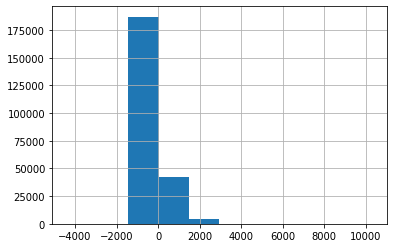

In [19]:
train_test_transformed[:train.shape[0]][train_test_transformed[:train.shape[0]].isFraud==0]['dist1-smoothed_encoded_card1_on_dist1_nanmedian'].hist()

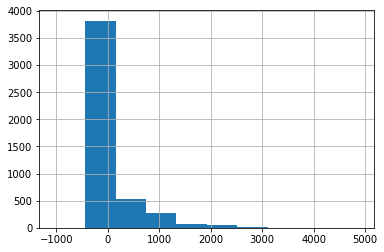

In [20]:
train_test_transformed[:train.shape[0]][train_test_transformed[:train.shape[0]].isFraud==1]['dist1-smoothed_encoded_card1_on_dist1_nanmedian'].hist()

In [11]:
from feature_engineering import encode_categorical_features

In [12]:
train_test_transformed, encoders = encode_categorical_features(
        train_test_transformed,
        ['device_name']
    )

In [7]:
from sklearn.model_selection import GroupKFold

In [8]:
folds = GroupKFold(n_splits=6)

In [13]:
gbms = []

preds = []

for fold_ind, (train_idx, val_idx) in enumerate(
    folds.split(
        X=train_test_transformed[:train.shape[0]], 
        y=train_test_transformed[:train.shape[0]]['isFraud'], 
        groups=train_test_transformed[:train.shape[0]]['TransactionDT_split'].tolist()
    )
):
    
    COLS_TO_USE = [
        i for i in train_test_transformed.columns
        if i not in COLUMNS_TO_REMOVE + TO_RM
    ]
    
    print('Fold', fold_ind)
    
    pars = {
        'num_leaves': 2 ** 7 - 1,
        #'min_data_in_leaf': 10,
        'learning_rate': 0.01,
        'feature_fraction': 0.9 ,
        'bagging_fraction': 0.9,
        'bagging_freq': 51,
        'cat_smooth': 209,
        'lambda_l1': 1.0,
        'lambda_l2': 3.0,
        'max_bin': 100,
        'scale_pos_weight': 7.0,
        #'max_cat_to_onehot': 10,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['auc'],
        'num_threads': -1
    }
    
    cat_c = [i for i in CATEGORICAL_FEATURES
        if i in COLS_TO_USE]
    
    cur_train = train_test_transformed[:train.shape[0]].iloc[train_idx]
    
    cur_test = train_test_transformed[:train.shape[0]].iloc[val_idx]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(cur_train[COLS_TO_USE], cur_train['isFraud'])
    lgb_eval = lgb.Dataset(cur_test[COLS_TO_USE], cur_test['isFraud'], reference=lgb_train)
    
    gbm = lgb.train(
        pars,
        lgb_train,
        num_boost_round=20000,
        valid_sets=(lgb_train, lgb_eval),
        valid_names=('train', 'valid'),
        early_stopping_rounds=100,
        feature_name=COLS_TO_USE,
        categorical_feature=cat_c + ['device_name'],
        verbose_eval=100
    )
    
    gbms.append(gbm)
    preds.append(gbm.predict(train_test_transformed.iloc[train.shape[0]:][COLS_TO_USE]))

Fold 0


/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'OS_NAME', 'OS_V0', 'OS_V1', 'OS_V2', 'OS_V_MAJOR', 'P_emaildomain', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'ProductCD', 'R_emaildomain', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'addr1', 'addr2', 'card2', 'card3', 'card4', 'card5', 'card6', 'device_name', 'is_foreign', 'is_holiday']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/miniconda3/envs/FRAUD/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.949335	valid's auc: 0.884875
[200]	train's auc: 0.9631	valid's auc: 0.893462
[300]	train's auc: 0.972156	valid's auc: 0.899616
[400]	train's auc: 0.97844	valid's auc: 0.904039
[500]	train's auc: 0.983193	valid's auc: 0.907598
[600]	train's auc: 0.986766	valid's auc: 0.909987
[700]	train's auc: 0.989534	valid's auc: 0.9117
[800]	train's auc: 0.991582	valid's auc: 0.913097
[900]	train's auc: 0.993245	valid's auc: 0.913868
[1000]	train's auc: 0.994508	valid's auc: 0.914727
[1100]	train's auc: 0.995544	valid's auc: 0.91493
[1200]	train's auc: 0.996343	valid's auc: 0.915291
[1300]	train's auc: 0.997019	valid's auc: 0.915347
[1400]	train's auc: 0.99752	valid's auc: 0.915689
[1500]	train's auc: 0.997969	valid's auc: 0.915949
[1600]	train's auc: 0.998337	valid's auc: 0.916203
[1700]	train's auc: 0.99861	valid's auc: 0.915993
Early stopping, best iteration is:
[1619]	train's auc: 0.998396	valid's auc: 0.916279
F

In [20]:
np.array([i.best_score['valid']['auc'] for i in gbms]).mean()

0.9386379407915114

In [15]:
import scipy

In [16]:
scipy.stats.gmean(np.array(preds), axis=0)

array([0.0044578 , 0.00670188, 0.0059508 , ..., 0.02742814, 0.04428766,
       0.01418365])

In [17]:
sample_submission['TransactionID'] = train_test_transformed.iloc[train.shape[0]:].index
sample_submission['isFraud'] = scipy.stats.gmean(np.array(preds), axis=0)
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.004458
1,3663550,0.006702
2,3663551,0.005951
3,3663552,0.004074
4,3663553,0.004610


In [18]:
vv = np.array([i.best_score['valid']['auc'] for i in gbms]).mean()
filename = f'submit_ts_kfold_{vv}.csv'
sample_submission.to_csv(filename, index=None)

In [19]:
!KAGGLE_USERNAME=merkylove KAGGLE_KEY=d5a91994e09f1cb75e62c8b8b2967594 kaggle competitions submit ieee-fraud-detection -f {filename} -m "auto"

100%|██████████████████████████████████████| 13.8M/13.8M [00:01<00:00, 14.1MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [22]:
COLS_TO_USE

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V

In [34]:
COLS_TO_USE =['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V18',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V19',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V2',
 'V20',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V21',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V22',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V23',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V24',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V25',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V26',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V27',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V28',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V32',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V33',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V4',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V5',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V6',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V7',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V8',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V9',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'addr1',
 'addr2',
#  'card2',
#  'card3',
 'card4',
 'card5',
 'card6',
 'dist1',
 'dist2',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
#  'id_12',
#  'id_13',
#  'id_14',
#  'id_15',
#  'id_16',
#  'id_17',
#  'id_18',
#  'id_19',
#  'id_20',
#  'id_21',
#  'id_22',
#  'id_23',
#  'id_24',
#  'id_25',
#  'id_26',
#  'id_27',
#  'id_28',
#  'id_29',
#  'id_30',
#  'id_31',
#  'id_32',
#  'id_33',
#  'id_34',
#  'id_35',
#  'id_36',
#  'id_37',
#  'id_38',
 'TransactionDT_dayOfMonth',
 'TransactionDT_dayOfWeek',
 'TransactionDT_weekOfMonth',
 'TransactionDT_hour',
 'is_holiday',
 'is_foreign',
 'OS_NAME',
 'OS_V0',
 'OS_V1',
 'OS_V2',
 'OS_V_COMBINED',
 'OS_V_MAJOR',
 'id_33_height',
 'id_33_width',
 'P_emaildomain_1',
 'P_emaildomain_2',
 'P_emaildomain_3',
 'R_emaildomain_1',
 'R_emaildomain_2',
 'R_emaildomain_3',
 'R=P',
 'R1=P1',
 'card1_count',
 'card2_count',
 'card3_count',
 'card4_count',
 'card5_count',
 'card6_count',
 'addr1_count',
 'addr2_count',
 'TransactionDT_hour_count',
 'card1_TransactionDT_hour_count',
 'card1_TransactionDT_hour_count_how_typical',
 'TransactionDT_dayOfMonth_count',
 'TransactionDT_weekOfMonth_count',
 'DeviceInfo_count',
 'OS_NAME_count',
 'P_emaildomain_count',
 'R_emaildomain_count',
 'card1_TransactionAmt_count',
 'card1_TransactionAmt_count_how_typical',
 'card1_P_emaildomain_count',
 'card1_P_emaildomain_count_how_typical',
 'card1_R_emaildomain_count',
 'card1_R_emaildomain_count_how_typical',
 'card1_addr1_count',
 'card1_addr1_count_how_typical',
 'card1_addr2_count',
 'card1_addr2_count_how_typical',
 'card1_TransactionDT_dayOfWeek_count',
 'card1_TransactionDT_dayOfWeek_count_how_typical',
 'card1_DeviceInfo_count',
 'card1_DeviceInfo_count_how_typical',
 'card1_dist1_count',
 'card1_dist1_count_how_typical',
 'card1_dist2_count',
 'card1_dist2_count_how_typical',
 'card1_OS_NAME_count',
 'card1_OS_NAME_count_how_typical',
 'card1_C13_count',
 'card1_C13_count_how_typical',
 'card1_C14_count',
 'card1_C14_count_how_typical',
 'card1_C1_count',
 'card1_C1_count_how_typical',
 'id_12_count',
 'id_13_count',
 'id_14_count',
 'id_15_count',
 'id_16_count',
 'id_17_count',
 'id_18_count',
 'id_19_count',
 'id_20_count',
 'id_21_count',
 'id_22_count',
 'id_23_count',
 'id_24_count',
 'id_25_count',
 'id_26_count',
 'id_27_count',
 'id_28_count',
 'id_29_count',
 'id_30_count',
 'id_31_count',
 'id_32_count',
 'id_33_count',
 'id_34_count',
 'id_35_count',
 'id_36_count',
 'id_37_count',
 'id_38_count',
 'card1_TransactionDT_split_TransactionDT_dayOfMonth_count',
 'card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_count',
 'smoothed_encoded_card1_on_TransactionAmt_mean',
 'smoothed_encoded_card1_on_TransactionAmt_std',
 'smoothed_encoded_card1_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_hour_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_dayOfMonth_on_TransactionAmt_nanmedian',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_mean',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_std',
 'smoothed_encoded_TransactionDT_weekOfMonth_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_mean',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_std',
 'smoothed_encoded_card1_TransactionDT_hour_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_mean',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_std',
 'smoothed_encoded_card1_TransactionDT_dayOfWeek_on_TransactionAmt_nanmedian',
 'smoothed_encoded_card1_on_dist1_mean',
 'smoothed_encoded_card1_on_dist1_std',
 'smoothed_encoded_card1_on_dist1_nanmedian',
 'smoothed_encoded_card1_on_dist2_mean',
 'smoothed_encoded_card1_on_dist2_std',
 'smoothed_encoded_card1_on_dist2_nanmedian',
 'smoothed_encoded_card1_on_TransactionDT_hour_nunique',
 'smoothed_encoded_card1_on_TransactionDT_hour_mean',
 'smoothed_encoded_card1_on_OS_NAME_nunique',
 'smoothed_encoded_card1_on_C13_nunique',
 'smoothed_encoded_card1_on_C14_nunique',
 'smoothed_encoded_card1_on_C1_nunique',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_on_TransactionAmt_sum',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_on_TransactionAmt_mean',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_sum',
 'smoothed_encoded_card1_TransactionDT_split_TransactionDT_dayOfMonth_TransactionDT_hour_on_TransactionAmt_mean',

             ]
              
              
len(COLS_TO_USE)

529

In [51]:
train_test_transformed[:train.shape[0]][train_test_transformed[:train.shape[0]]['isFraud'] == 1].TransactionAmt.describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

In [52]:
train_test_transformed[:train.shape[0]][train_test_transformed[:train.shape[0]]['isFraud'] == 0].TransactionAmt.describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [ ]:
for i in range(1, 39):
    print(f'id_')

In [55]:
for i in train.columns.tolist():
    print(i, sum(train[i].notnull()), sum(~train[i].notnull()))

isFraud 590540 0
TransactionDT 590540 0
TransactionAmt 590540 0
ProductCD 590540 0
card1 590540 0
card2 581607 8933
card3 588975 1565
card4 588963 1577
card5 586281 4259
card6 588969 1571
addr1 524834 65706
addr2 524834 65706
dist1 238269 352271
dist2 37627 552913
P_emaildomain 496084 94456
R_emaildomain 137291 453249
C1 590540 0
C2 590540 0
C3 590540 0
C4 590540 0
C5 590540 0
C6 590540 0
C7 590540 0
C8 590540 0
C9 590540 0
C10 590540 0
C11 590540 0
C12 590540 0
C13 590540 0
C14 590540 0
D1 589271 1269
D2 309743 280797
D3 327662 262878
D4 421618 168922
D5 280699 309841
D6 73187 517353
D7 38917 551623
D8 74926 515614
D9 74926 515614
D10 514518 76022
D11 311253 279287
D12 64717 525823
D13 61952 528588
D14 62187 528353
D15 501427 89113
M1 319440 271100
M2 319440 271100
M3 319440 271100
M4 309096 281444
M5 240058 350482
M6 421180 169360
M7 244275 346265
M8 244288 346252
M9 244288 346252
V1 311253 279287
V2 311253 279287
V3 311253 279287
V4 311253 279287
V5 311253 279287
V6 311253 279287
V7

In [163]:
c_ = 'DeviceInfo'
train[train[c_].isnull()]['isFraud'].describe(), train[train[c_].notnull()]['isFraud'].describe()

(count    471874.000000
 mean          0.025549
 std           0.157786
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: isFraud, dtype: float64, count    118666.000000
 mean          0.072531
 std           0.259367
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: isFraud, dtype: float64)

In [121]:
np.corrcoef(train['V167'].dropna().iloc[:1000], train['V238'].dropna().iloc[:1000])

array([[1.        , 0.11814085],
       [0.11814085, 1.        ]])

In [62]:
train[train['card2'].notnull()]['isFraud'].describe()

count    581607.000000
mean          0.034800
std           0.183273
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

In [59]:
sum(test['id_22'].isnull())

501629